## Nettoyage, Feature engineering, Analyse descriptive univariée et bivariée / inférentielle des données (avec dataviz et tests statistiques)

Temps de calcul de toutes les cellules de ce Jupyter Notebook : env. 2 min 30 s (MacBook Pro 2,6 GHz Intel Core i7 6 cœurs - 32 Go 2400 MHz DDR4)

In [386]:
# Importation de librairies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import locale

In [ ]:
# Réglage de l'heure locale (utilisée pour avoir les xticks des "mois - année" en français et non en anglais (Cf. plus bas))
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

In [388]:
# Importation des données brutes (multiclass) dans un DataFrame
df = pd.read_csv('../data/raw/scraped_reviews_final.csv')

In [ ]:
# Affichage des 5 premières lignes
df.head()

In [390]:
# Nbre de lignes et de colonnes
print(f'Le DataFrame comporte {df.shape[0]} lignes et {df.shape[1]} colonnes. \n')

# Infos sur le DataFrame
df.info()

Le DataFrame comporte 55198 lignes et 8 colonnes. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55198 entries, 0 to 55197
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   pseudo            55196 non-null  object
 1   publication_date  55198 non-null  object
 2   rating            55198 non-null  int64 
 3   title             55198 non-null  object
 4   review            48394 non-null  object
 5   experience_date   55198 non-null  object
 6   total_reviews     55198 non-null  int64 
 7   bank              55198 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.4+ MB


### Nettoyage des doublons et des valeurs manquantes

In [ ]:
# Nbre de lignes en doublon
print(f'Il y a {df.duplicated().sum()} ligne(s) en doublon dans le DataFrame.')

# Lignes en doublon
df[df.duplicated(keep=False)].sort_values(by='pseudo')

In [392]:
# Suppression des lignes en doublon et Réinitialisation de l'index
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Nbre de lignes en doublon restantes
print(f'Il y a {df.duplicated().sum()} ligne(s) en doublon restante(s) dans le DataFrame.')

Il y a 0 ligne(s) en doublon restante(s) dans le DataFrame.


In [ ]:
'''
# Affichage des éventuels mêmes clients (même "pseudo", même "total_reviews") ayant publié plusieurs avis en moins de 30 min pour une même banque

# Tri sur 4 colonnes
df_temp = df.sort_values(by=['pseudo', 'total_reviews', 'bank', 'publication_date'])

# Conversion au format DateTime
df_temp['publication_date'] = pd.to_datetime(df_temp['publication_date']).dt.tz_convert('Europe/Paris')

# Différence temporelle avec chacune des lignes précédentes et suivantes
df_temp['diff_seconds_prev'] = df_temp.groupby(['pseudo', 'total_reviews', 'bank'])['publication_date'].diff().dt.total_seconds()
df_temp['diff_seconds_next'] = (df_temp.groupby(['pseudo', 'total_reviews', 'bank'])['publication_date'].shift(-1) - df_temp['publication_date']).dt.total_seconds()

# Minimum des 2 différences (précédente et suivante)
df_temp['diff_seconds'] = df_temp[['diff_seconds_prev', 'diff_seconds_next']].min(axis=1)

# Lignes en doublon (différence <= 30 min)
df_temp[df_temp['diff_seconds'].between(0, 1800)]
'''

In [394]:
# Nbre de valeurs manquantes
print(f'Il y a {df.isna().sum().sum()} valeur(s) manquante(s) dans le DataFrame.')

# Nbre de valeurs manquantes par colonne
df.isna().sum()

Il y a 6804 valeur(s) manquante(s) dans le DataFrame.


pseudo                 2
publication_date       0
rating                 0
title                  0
review              6802
experience_date        0
total_reviews          0
bank                   0
dtype: int64

In [395]:
# Suppression des lignes comportant au moins 1 valeur manquante et Réinitialisation de l'index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Nbre de valeurs manquantes restantes
print(f'Il y a {df.isna().sum().sum()} valeur(s) manquante(s) restante(s) dans le DataFrame.')

Il y a 0 valeur(s) manquante(s) restante(s) dans le DataFrame.


In [ ]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

### Description des variables et Conversion du type des variables

In [ ]:
# Nom des colonnes / variables et leur Description
#print(*df.columns, sep='\n')
'''
pseudo : Pseudo du client
publication_date : Date de publication de l'avis du client --> À CONVERTIR EN DATETIME (heure de Paris)
rating : Note liée à l'avis du client
title : Titre de l'avis du client
review : Texte de l'avis du client
experience_date : Date de l'expérience notée par le client --> À CONVERTIR EN DATETIME
total_reviews : Nombre d'avis écrits par le client
bank : Banque notée par le client
'''

In [398]:
# Conversion au format DateTime (heure de Paris)
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce').dt.tz_convert('Europe/Paris')

In [ ]:
# Dictionnaire de conversion
mois_fr_en = {
    'janvier': 'January', 'février': 'February', 'mars': 'March', 'avril': 'April', 'mai': 'May', 'juin': 'June',
    'juillet': 'July', 'août': 'August', 'septembre': 'September', 'octobre': 'October', 'novembre': 'November', 'décembre': 'December'
}

# Remplacement des mois en français par les mois en anglais
df['experience_date'] = df['experience_date'].str.lower().replace(mois_fr_en, regex=True)

# Conversion au format DateTime
df['experience_date'] = pd.to_datetime(df['experience_date'], errors='coerce')

In [ ]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

In [401]:
# Nbre de valeurs uniques et Valeurs par variable
for col in df.columns:
    print(f'{col} : {df[col].nunique(dropna=False)} valeurs uniques.')
    if df[col].nunique(dropna=False) <= 10:
        print(df[col].unique())
    print('\n')

pseudo : 38150 valeurs uniques.


publication_date : 48313 valeurs uniques.


rating : 5 valeurs uniques.
[5 4 2 1 3]


title : 34846 valeurs uniques.


review : 45214 valeurs uniques.


experience_date : 2295 valeurs uniques.


total_reviews : 80 valeurs uniques.


bank : 4 valeurs uniques.
['boursobank' 'fortuneo' 'hellobank' 'monabanq']




### Variables catégorielles

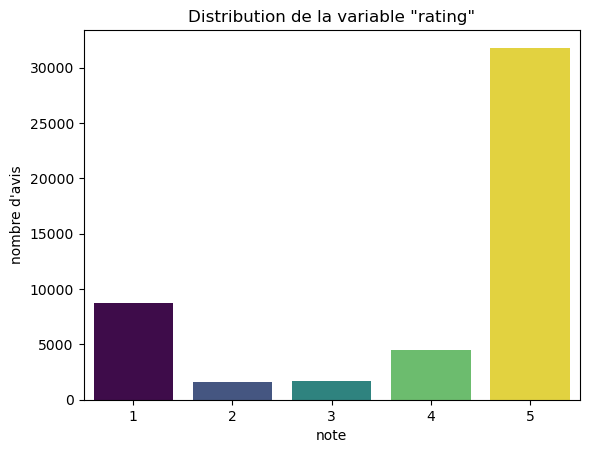

In [402]:
# Distribution de la variable "rating"
sns.countplot(x='rating', hue='rating', data=df, palette='viridis', legend=False)
plt.xlabel('note')
plt.ylabel('nombre d\'avis')
plt.title('Distribution de la variable "rating"');

In [ ]:
'''On constate un fort déséquilibre dans la distribution de la variable "rating". --> À TRAITER PAR LA SUITE'''

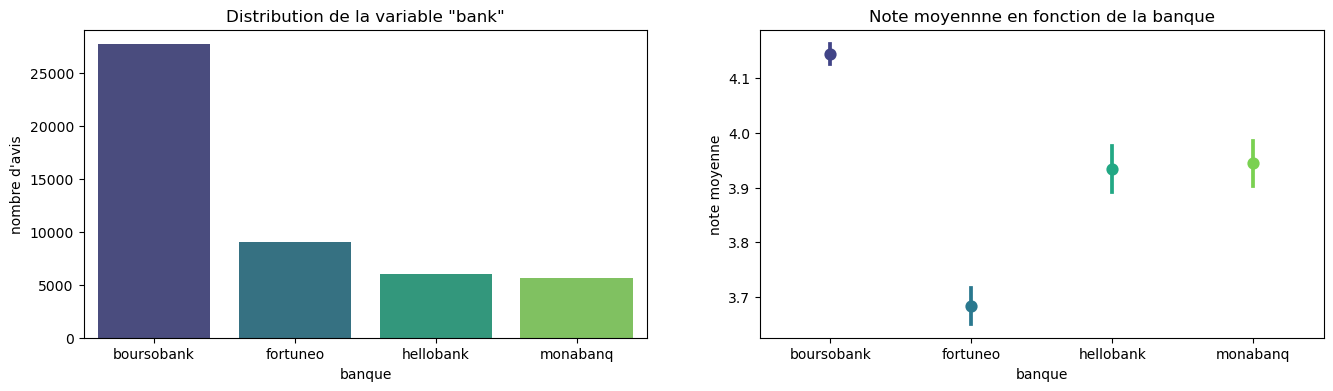

In [ ]:
# Distribution de la variable "bank"
fig, axes = plt.subplots(1, 2, figsize=(16,4))

sns.countplot(x='bank', hue='bank', data=df, palette='viridis', legend=False, ax=axes[0])
axes[0].set_xlabel('banque')
axes[0].set_ylabel('nombre d\'avis')
axes[0].set_title('Distribution de la variable "bank"')

sns.pointplot(x='bank', y='rating', hue='bank', data=df, palette='viridis', legend=False, ax=axes[1])
axes[1].set_xlabel('banque')
axes[1].set_ylabel('note moyenne')
axes[1].set_title('Note moyennne en fonction de la banque')

plt.show()

In [ ]:
'''
On constate un fort déséquilibre dans la distribution de la variable "bank" mais qui n'aura pas de conséquence
car nous décidons de traiter ces 4 banques en ligne comme une seule et même banque en ligne.
Nous ne garderons pas cette variable par la suite. --> À SUPPRIMER PAR LA SUITE
'''

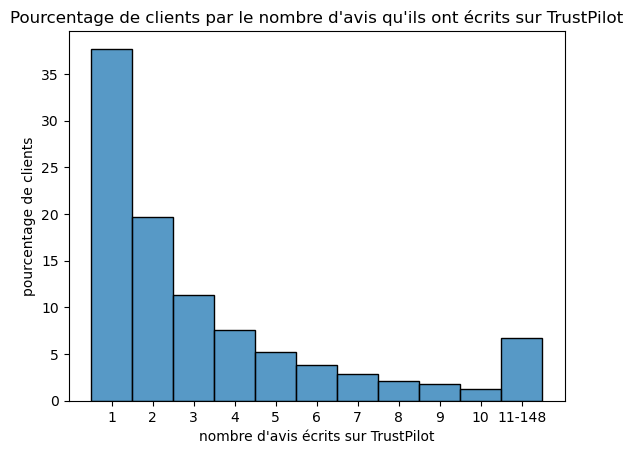

In [406]:
# Pourcentage de clients par le nombre d'avis qu'ils ont écrits sur TrustPilot
df_filtered = df[['pseudo', 'total_reviews']].drop_duplicates()

df_filtered['total_reviews'] = pd.cut(x=df_filtered['total_reviews'],
                                      bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, df['total_reviews'].max()],
                                      labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', f"11-{df['total_reviews'].max()}"])

sns.histplot(x='total_reviews', data=df_filtered, stat='percent', discrete=True, legend=False)
#sns.countplot(x='total_reviews', hue='total_reviews', data=df_filtered, stat='percent', palette='viridis', legend=False)
plt.xlabel('nombre d\'avis écrits sur TrustPilot')
plt.ylabel('pourcentage de clients')
plt.title('Pourcentage de clients par le nombre d\'avis qu\'ils ont écrits sur TrustPilot');

In [ ]:
'''
On constate que plus de la moitié des clients (même "pseudo", même "total_reviews") a écrit 1 ou 2 avis sur TrustPilot.

>>> Attention <<< À noter que les pseudos ne sont pas uniques.
2 clients (ou plus) ayant le même pseudo et le même nombre d'avis écrits sur TrustPilot sont vus comme étant 1 même client.
'''

In [ ]:
'''
# Autres manières de faire :

df_groupe = df.groupby(['pseudo', 'total_reviews'])['total_reviews'].first().droplevel(1)
df_groupe = pd.cut(x=df_groupe, bins=[0, 50, 100, 200], labels=['0-50', '51-100', '101-200'])
sns.countplot(x=df_groupe, stat='percent', palette='viridis', legend=False)

df_groupe = df.groupby(['pseudo', 'total_reviews'])['total_reviews'].first().droplevel(1)
df_dataframe = pd.DataFrame(df_groupe)
df_dataframe['total_reviews'] = pd.cut(x=df_dataframe['total_reviews'], bins=[0, 50, 100, 200], labels=['0-50', '51-100', '101-200'])
sns.countplot(x='total_reviews', data=df_dataframe, stat='percent', palette='viridis', legend=False)
'''

### Variables temporelles

#### Feature engineering des variables temporelles

In [409]:
# Création de nouvelles variables à partir de la variable "publication_date"
df['year'] = df['publication_date'].dt.year
df['month'] = df['publication_date'].dt.month
df['year_month'] = df['publication_date'].dt.strftime('%Y-%m')
df['weekday'] = df['publication_date'].dt.weekday   # OU df['weekday'] = df['publication_date'].dt.strftime('%A')   # Renvoie les noms entiers en français des jours de la semaine.
df['hour'] = df['publication_date'].dt.hour

In [ ]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

In [411]:
# Filtrage sur la "publication_date" entre le 01/01/2015 et le 31/12/2024
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2024-12-31')

df_filtered = df[df['publication_date'].dt.tz_convert(None).between(start_date, end_date)]

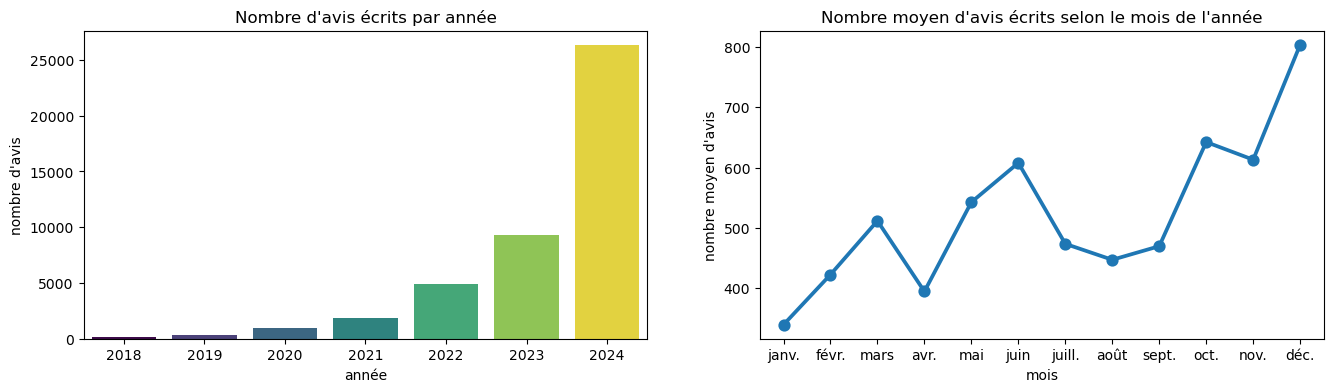

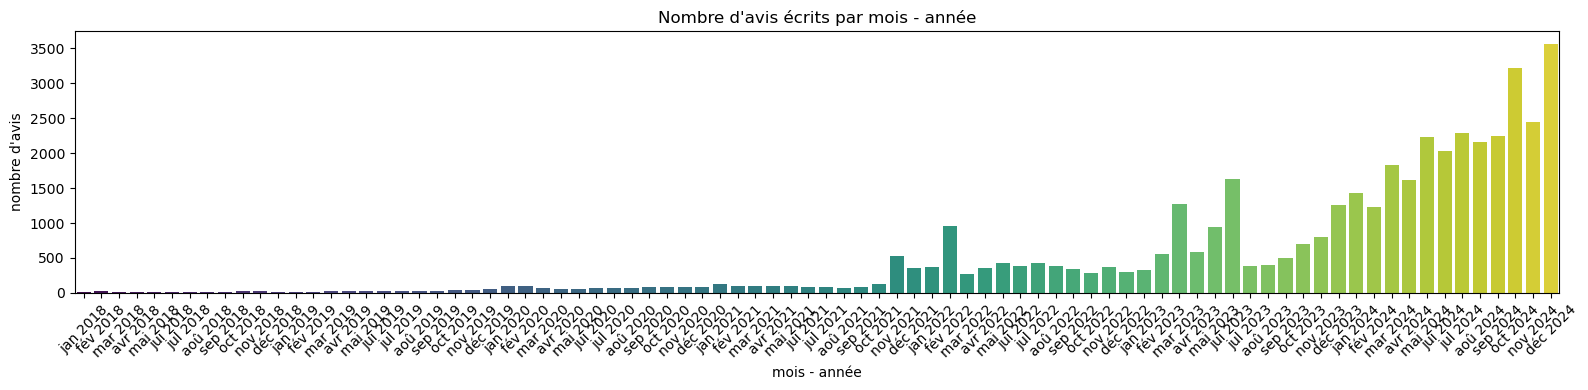

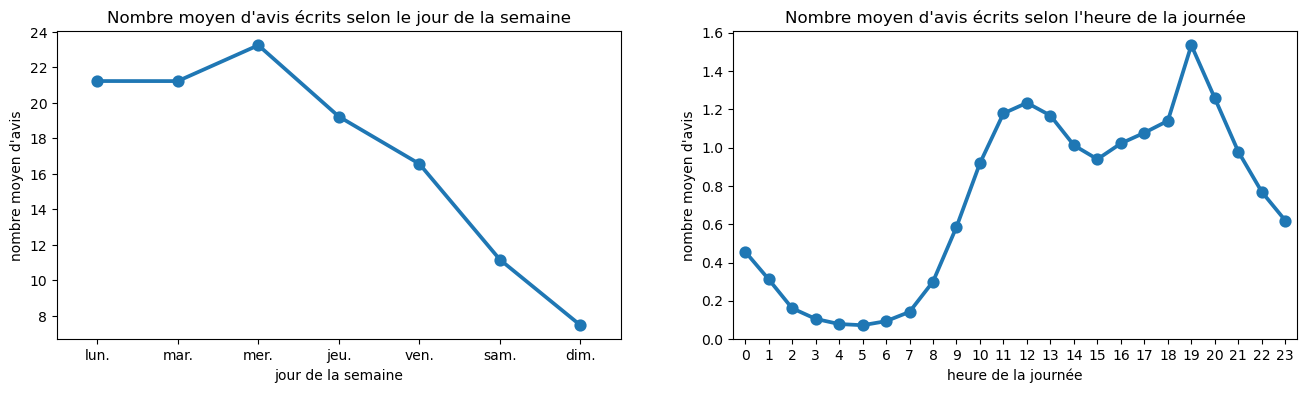

In [ ]:
# Distributions des variables "year" et "year_month", et Moyennes des variables "month", "weekday" et "hour"
fig, axes = plt.subplots(1, 2, figsize=(16,4))

sns.countplot(x='year', hue='year', data=df_filtered, palette='viridis', legend=False, ax=axes[0])
axes[0].set_xlabel('année')
axes[0].set_ylabel('nombre d\'avis')
axes[0].set_title('Nombre d\'avis écrits par année')

monthly_avg_reviews = df_filtered.groupby('month').size() / df_filtered['year'].nunique()
sns.pointplot(x=monthly_avg_reviews.index, y=monthly_avg_reviews.values, order=range(1, 13), legend=False, ax=axes[1])
#sns.lineplot(x=monthly_avg_reviews.index, y=monthly_avg_reviews.values), ax=axes[1])
#sns.countplot(x='month', hue='month', data=df_filtered, order=range(1, 13), palette='viridis', legend=False, ax=axes[1])
axes[1].set_xticks(range(12))
axes[1].set_xticklabels(['janv.', 'févr.', 'mars', 'avr.', 'mai', 'juin', 'juill.', 'août', 'sept.', 'oct.', 'nov.', 'déc.'])
axes[1].set_xlabel('mois')
axes[1].set_ylabel('nombre moyen d\'avis')
axes[1].set_title('Nombre moyen d\'avis écrits selon le mois de l\'année')


fig, axe = plt.subplots(1, 1, figsize=(16,4))

sns.countplot(x='year_month', hue='year_month', data=df_filtered.sort_values(by='year_month'),
              order=pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m'), palette='viridis', legend=False, ax=axe)
# Autre manière de faire : sns.barplot(data=df_filtered['year_month'].value_counts().sort_index(),
#                                      order=pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m'), palette='viridis', legend=False, ax=axe)
axe.set_xticks(range(len(pd.date_range(start=start_date, end=end_date, freq='MS'))))
axe.set_xticklabels(pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%b %Y'), rotation=45)
axe.set_xlabel('mois - année')
axe.set_ylabel('nombre d\'avis')
axe.set_title('Nombre d\'avis écrits par mois - année')
plt.tight_layout()


fig, axes = plt.subplots(1, 2, figsize=(16,4))

weekly_avg_reviews = df_filtered.groupby('weekday').size() / np.round((end_date - start_date).days / 7, decimals=2)
sns.pointplot(x=weekly_avg_reviews.index, y=weekly_avg_reviews.values, order=range(7), legend=False, ax=axes[0])
#sns.lineplot(x=weekly_avg_reviews.index, y=weekly_avg_reviews.values), ax=axes[0])
#sns.countplot(x='weekday', hue='weekday', data=df_filtered, order=range(0, 7), palette='viridis', legend=False, ax=axes[0])
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['lun.', 'mar.', 'mer.', 'jeu.', 'ven.', 'sam.', 'dim.'])
axes[0].set_xlabel('jour de la semaine')
axes[0].set_ylabel('nombre moyen d\'avis')
axes[0].set_title('Nombre moyen d\'avis écrits selon le jour de la semaine')

hourly_avg_reviews = df_filtered.groupby('hour').size() / (end_date - start_date).days
sns.pointplot(x=hourly_avg_reviews.index, y=hourly_avg_reviews.values, order=range(24), legend=False, ax=axes[1])
#sns.lineplot(x=hourly_avg_reviews.index, y=hourly_avg_reviews.values), ax=axes[1])
#sns.countplot(x='hour', hue='hour', data=df_filtered, order=range(24), palette='viridis', legend=False, ax=axes[1])
axes[1].set_xlabel('heure de la journée')
axes[1].set_ylabel('nombre moyen d\'avis')
axes[1].set_title('Nombre moyen d\'avis écrits selon l\'heure de la journée')


plt.show()

In [ ]:
'''
On constate :

- une augmentation du nombre d'avis écrits sur TrustPilot d'année en année pour les 4 banques en ligne toutes confondues (Boursobank, Fortuneo, Hellobank, Monabanq).

- un pic du nombre moyen d'avis écrits sur les mois de Décembre, suivi d'une chute sur les mois de Janvier (Cf. ci-dessous) ; un creux sur les mois d'Avril (Cf. ci-dessous) ;
  un pic sur les mois de Juin suivi d'une période creuse pendant les périodes estivales.

- un nombre relativement important d'avis écrits en Janvier 2022 et Janvier 2023 (plus important qu'en Décembre 2022), ainsi qu'en Avril 2023 et Avril 2024.
  Le constat précédent sur la chute / creux du nombre d'avis écrits sur les mois de Janvier / d'Avril est donc à prendre avec des pincettes.

- un nombre moyen d'avis écrits au plus haut les Lundis, Mardis et Mercredis, suivi d'une baisse au fur et à mesure que l'on avance dans la semaine,
  pour atteindre le niveau le plus bas les Dimanches.

- enfin, un nombre moyen élevé d'avis écrits aux alentours de 12h (heure du déjeuner), suivi d'une petite baisse dans l'après-midi, puis d'un pic en fin de journée vers 19h.
'''

### Variables textuelles

#### WordCloud

In [414]:
# Importation de la librairie WordCloud
from wordcloud import WordCloud

In [415]:
# Fonction pour afficher un nuage de mots
def plot_wordcloud(string, random_state, title='Nuage de mots', colormap='viridis', subplot=None, stopwords=None):

    """
    Definition :
    - Plots a word cloud after tokenizing the data string into words / groups of words ; removing special characters (including punctuation, emojis, ...),
      digits, and English stop words ; and calculating the frequencies of the tokens.

    Parameters :
    - string (str) : The data string to plot as a word cloud. (First, use ' '.join(document for document in df['corpus']) before calling the function)
    - random_state (int) : The integer that controls randomness for reproducibility.
    - title (str) : The title of the word cloud. Default is 'Nuage de mots'.
    - colormap (str) : The map of colors representing data values. (e.g. : 'plasma', 'cividis', 'Greens', 'Reds', 'summer', 'hot') Default is 'viridis'.
    - subplot (tuple of int) : A tuple specifying the grid layout. (e.g. : (1, 2, 1) : 1 row, 2 columns, ax 1)
    - stopwords (set) : A set of stop words.

    Returns :
    - A word cloud visualization.
    - A WordCloud object.
    """

    wc = WordCloud(prefer_horizontal=1, max_font_size=30, scale=4, colormap=colormap, random_state=random_state, stopwords=stopwords)
    wc.generate(string)

    if subplot:
        plt.subplot(*subplot)

    plt.title(title)
    plt.axis('off')

    plt.imshow(wc)
    return wc

In [416]:
# Création de 2 chaînes de caractères (corpus) rassemblant tous les avis, et tous les titres
all_reviews = ' '.join(review for review in df['review'])
all_titles = ' '.join(title for title in df['title'])

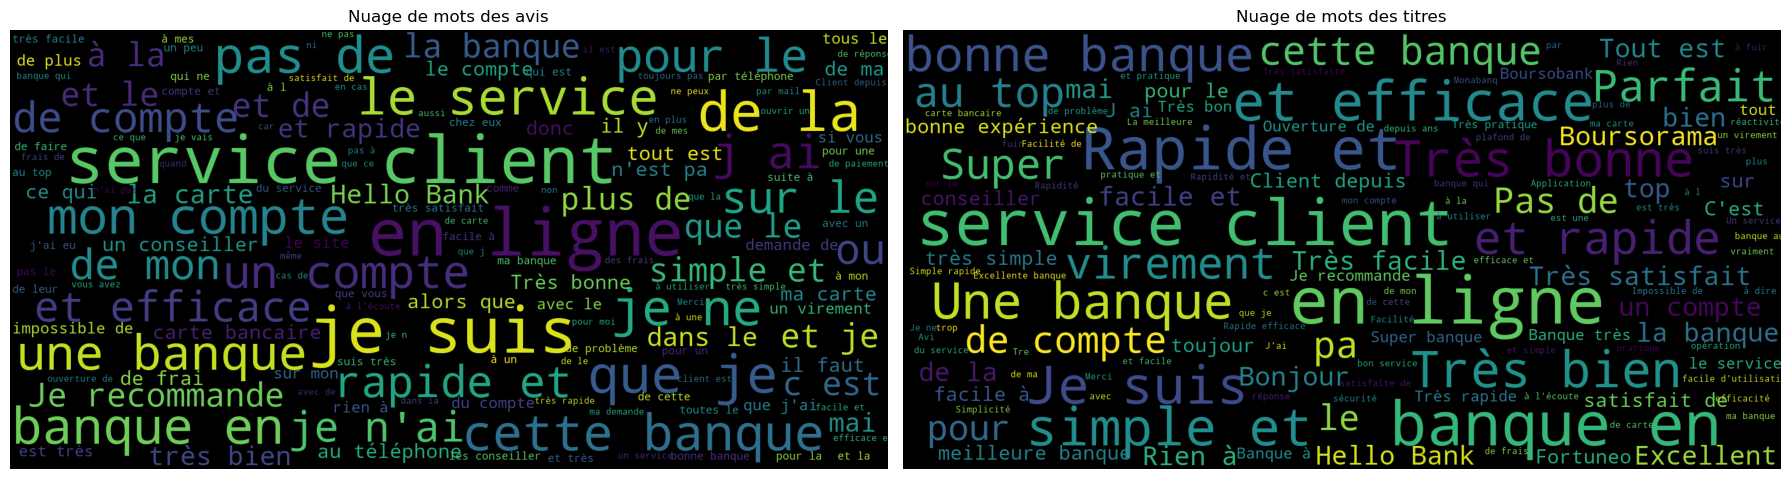

In [ ]:
# Nuages de mots de la variable "review" et de la variable "title"
plt.figure(figsize=(18,8))

wc1 = plot_wordcloud(all_reviews, 58, 'Nuage de mots des avis', subplot=(1, 2, 1))
wc2 = plot_wordcloud(all_titles, 38, 'Nuage de mots des titres', subplot=(1, 2, 2))

plt.tight_layout()
plt.show()

# Mots ou groupes de mots les plus fréquents dans ces nuages de mots
#display('Mots ou groupes de mots les plus fréquents parmi les avis :', list(wc1.words_.items())[:10])
#display('Mots ou groupes de mots les plus fréquents parmi les titres :', list(wc2.words_.items())[:10])

In [ ]:
'''
Constats :
- Le sujet du "service client" est prédominant dans les corpus, mais est-ce propre à des avis notés plutôt positivement et/ou plutôt négativement ? (Cf. plus bas)
- Certains mots / groupes de mots ne contiennent pas d'information discriminante pour la classification que l'on souhaite faire.
  (ex. : "pas de", "pour le", "de la", "je suis", "je ne", etc... ou bien "une banque", "Bonjour", "en ligne", etc... ou encore "Hello Bank", "Boursorama", etc...) --> À RETIRER
- Des majuscules sont présentes au début de certains mots / groupes de mots.  --> À MODIFIER
- Les termes sont 'tous' positifs (ex. : "simple et", "et efficace", "rapide et", etc...) ; cela est dû au déséquilibre de la variable "rating". (Cf. plus haut)


>>> Regardons de plus près les avis / titres notés "1", et les avis / titres notés "5".
'''

In [419]:
# Création de 2 chaînes de caractères (corpus) rassemblant les avis notés "1", et les titres notés "1"
rating_1_reviews = ' '.join(review for review in df[df['rating'] == 1]['review'])
rating_1_titles = ' '.join(title for title in df[df['rating'] == 1]['title'])

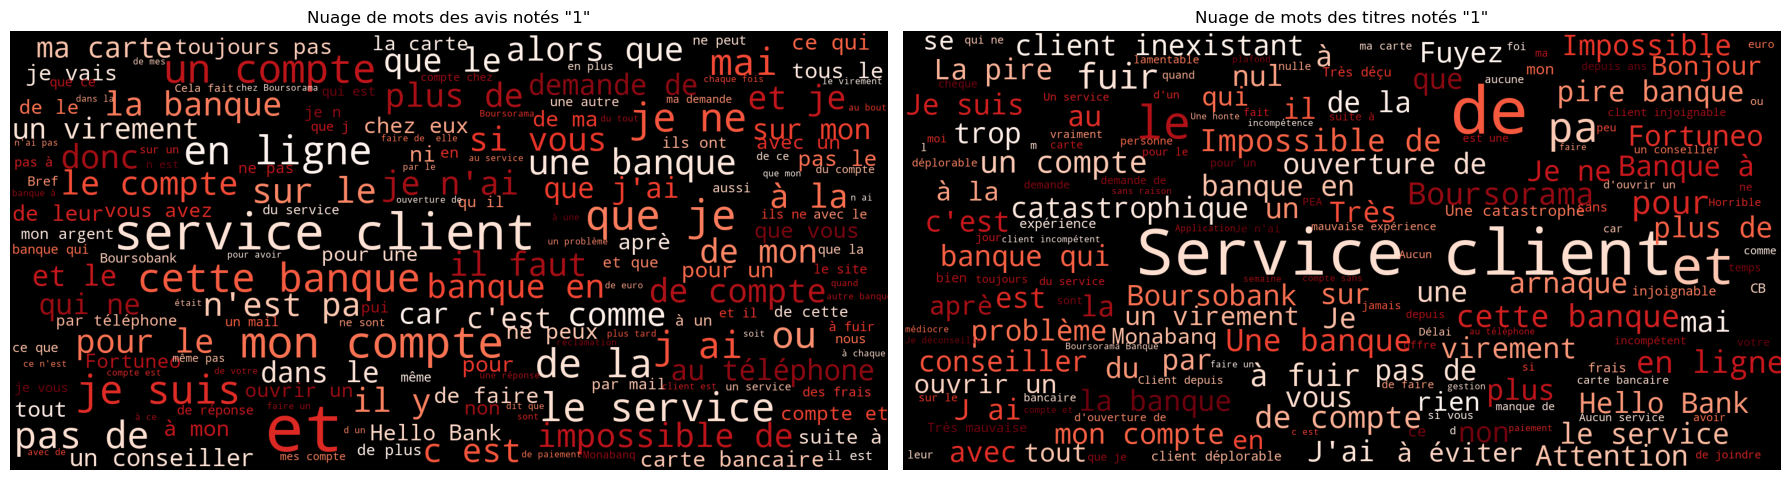

In [ ]:
# Nuages de mots de la variable "review" avec une note de "1" et de la variable "title" avec une note de "1"
plt.figure(figsize=(18,8))

wc1 = plot_wordcloud(rating_1_reviews, 68, 'Nuage de mots des avis notés "1"', 'Reds', subplot=(1, 2, 1))
wc2 = plot_wordcloud(rating_1_titles, 28, 'Nuage de mots des titres notés "1"', 'Reds', subplot=(1, 2, 2))

plt.tight_layout()
plt.show()

# Mots ou groupes de mots les plus fréquents dans ces nuages de mots
#display('Mots ou groupes de mots les plus fréquents parmi les avis notés "1" :', list(wc1.words_.items())[:10])
#display('Mots ou groupes de mots les plus fréquents parmi les titres notés "1" :', list(wc2.words_.items())[:10])

In [ ]:
'''
Constats :
- Le sujet du "service client" ressort de manière très forte dans les avis / titres notés "1".
- Certains mots / groupes de mots ne contiennent pas d'information discriminante pour la classification que l'on souhaite faire.
  (ex. : "chez eux", "je n'ai", "dans le", "de mon", "Je suis", etc... ou bien "banque en", "de compte", etc... ou encore "Fortuneo", "Hello Bank", etc...) --> À RETIRER
- Des majuscules sont présentes au début de certains mots / groupes de mots.  --> À MODIFIER
- Les termes négatifs ressortent (ex. : "impossible de", "catastrophique", "problème", "à fuir", "arnaque", etc...) mais sont de tout même noyés dans un certain bruit. (Cf. le 2e point)
'''

In [422]:
# Création de 2 chaînes de caractères (corpus) rassemblant les avis notés "5", et les titres notés "5"
rating_5_reviews = ' '.join(review for review in df[df['rating'] == 5]['review'])
rating_5_titles = ' '.join(title for title in df[df['rating'] == 5]['title'])

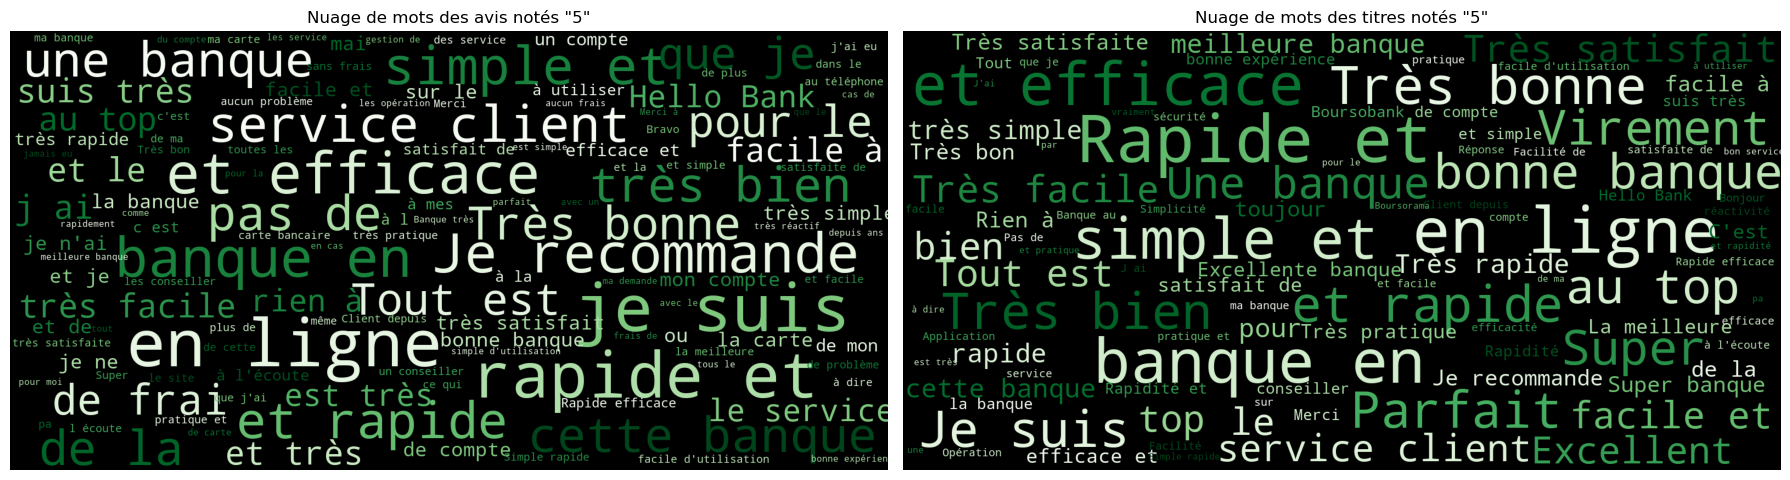

In [ ]:
# Nuages de mots de la variable "review" avec une note de "5" et de la variable "title" avec une note de "5"
plt.figure(figsize=(18,8))

wc1 = plot_wordcloud(rating_5_reviews, 68, 'Nuage de mots des avis notés "5"', 'Greens', subplot=(1, 2, 1))
wc2 = plot_wordcloud(rating_5_titles, 28, 'Nuage de mots des titres notés "5"', 'Greens', subplot=(1, 2, 2))

plt.tight_layout()
plt.show()

# Mots ou groupes de mots les plus fréquents dans ces nuages de mots
#display('Mots ou groupes de mots les plus fréquents parmi les avis notés "5" :', list(wc1.words_.items())[:10])
#display('Mots ou groupes de mots les plus fréquents parmi les titres notés "5" :', list(wc2.words_.items())[:10])

In [ ]:
'''
Constats :
- Le sujet du "service client" ressort moins dans les avis / titres notés "5".
- Certains mots / groupes de mots ne contiennent pas d'information discriminante pour la classification que l'on souhaite faire.
  (ex. : "et le", "que je", "tout est", "de la", etc... ou bien "banque en", "en ligne", "cette banque", etc... et de façon moindre "Hello Bank"
  (et peut-être aussi les autres noms de banques)) --> À RETIRER
- Des majuscules sont présentes au début de certains mots / groupes de mots.  --> À MODIFIER
- Les termes positifs ressortent (ex. : "et efficace", "très bien", "Je recommande", "Parfait", "Excellent", etc...) mais sont de tout même noyés dans un certain bruit. (Cf. le 2e point)


>>> Importons les mots vides français par défaut de NLTK puis Retirons-les des corpus rassemblant les avis notés "1", et les titres notés "1",
en utilisant WordCloud.
'''

#### NLTK

In [425]:
# Importation de la librairie NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist   # OU utiliser Counter() de Collections
#from nltk.stem import WordNetLemmatizer

In [426]:
# Accès à la pop-in NLTK (pour télécharger les mots vides français par défaut)
#import nltk
#nltk.download()   # OU directement : nltk.download('stopwords')

In [427]:
# Importation des mots vides français par défaut
default_stopwords = set(stopwords.words('french'))

display(default_stopwords)

{'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'as',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'c',
 'ce',
 'ces',
 'd',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'furent',
 'fus',
 'fusse',
 'fussent',
 'fusses',
 'fussiez',
 'fussions',
 'fut',
 'fûmes',
 'fût',
 'fûtes',
 'il',
 'ils',
 'j',
 'je',
 'l',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'm',
 'ma',
 'mais',
 'me',
 'mes',
 'moi',
 'mon',
 'même',
 'n',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ont',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 's',
 'sa',
 'se',
 'sera',
 'serai',
 'seraient',
 'serais',
 'serait',


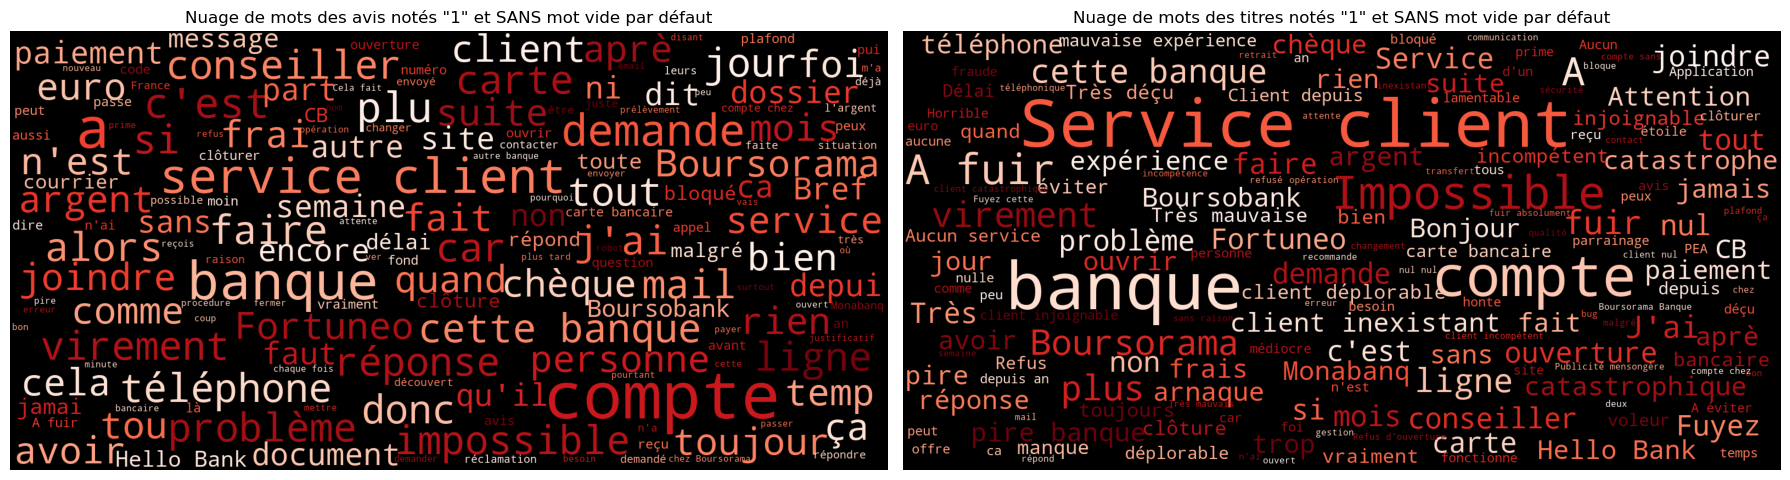

In [ ]:
# Nuages de mots de la variable "review" avec une note de "1" et de la variable "title" avec une note de "1", SANS mot vide par défaut
plt.figure(figsize=(18,8))

wc1 = plot_wordcloud(rating_1_reviews, 68, 'Nuage de mots des avis notés "1" et SANS mot vide par défaut', 'Reds', subplot=(1, 2, 1), stopwords=default_stopwords)
wc2 = plot_wordcloud(rating_1_titles, 28, 'Nuage de mots des titres notés "1" et SANS mot vide par défaut', 'Reds', subplot=(1, 2, 2), stopwords=default_stopwords)

plt.tight_layout()
plt.show()

# Mots ou groupes de mots les plus fréquents dans ces nuages de mots
#display('Mots ou groupes de mots les plus fréquents parmi les avis notés "1" et SANS mot vide par défaut :', list(wc1.words_.items())[:10])
#display('Mots ou groupes de mots les plus fréquents parmi les titres notés "1" et SANS mot vide par défaut :', list(wc2.words_.items())[:10])

In [ ]:
'''
Constats :
En retirant les mots vides par défaut via WordCloud, on note un bon début de nettoyage mais...
- ...Toujours certains mots / groupes de mots ne contenant pas d'information discriminante pour la classification que l'on souhaite faire.
  (ex. : "c'est", "si", "a", "alors", "J'ai", etc... ou bien "document", "mail", "mois", etc... ou encore "Fortuneo", "Hello Bank", "Monabanq", "Boursorama) --> À RETIRER
- ...Toujours des majuscules présentes au début de certains mots / groupes de mots, ce qui empêche que certains mots vides par défaut soient retirés. --> À MODIFIER
- Quelques fautes d'orthographe à noter ici et là. ("tou", "temp", "aprè", etc...)

>>> Attention <<< Comme indiqué dans la définition de la fonction plot_wordcloud() et comme on peut le voir dans les nuages de mots affichés,
WordCloud tokenise la chaîne de caractères en MOTS ou GROUPES DE MOTS (2-3 mots), ce qui est relativement pertinent pour de l'affichage en nuage de mots
mais qui ne permet pas de retirer des mots vides par défaut au sein de certains groupes de mots (ex. : "J'ai", "c'est", "d'une", "n'ai", etc...).

Nous choisissons pour la suite de créer des tokens à l'échelle du mot, et non du groupe de mots, afin que le plus grand nombre de mots vides soit retiré
et afin de ne pas avoir un vocabulaire (= ensemble des mots uniques présents dans un corpus) trop important. (Cf. plus bas la Lemmatisation)


>>> Utilisons la fonction de tokenisation word_tokenize() de NLTK puis Retirons les mots vides par défaut du corpus rassemblant les avis notés "1",
en utilisant une compréhension de liste.
'''

In [430]:
# Conversion en minuscules
rating_1_reviews_lower = rating_1_reviews.lower()

# Tokenisation de la chaîne de caractères rassemblant les avis notés "1"
tokens = word_tokenize(rating_1_reviews_lower, language='french')

# Ajout de mots vides personnalisés aux mots vides par défaut
custom_stopwords = ['boursorama', 'bourso rama', 'boursobank', 'bourso bank', 'boursobanque', 'bourso banque', 'boursobanq', 'bourso banq', 'bourso',
                    'fortuneo',
                    'hello bank', 'hellobank', 'hellobanque', 'hello banque', 'hellobanq', 'hello banq', 'hello',
                    'monabanq', 'mona banq', 'monabank', 'mona bank', 'monabanque', 'mona banque', 'mona',
                    'banque', 'bank',
                    'cette', 'chez', 'très', 'après', 'alors', 'ça', 'cela', 'comme', 'quand', 'non', 'temps', 'autre',
                    'mais', 'ou', 'et', 'donc', 'or', 'ni', 'car',
                    'a', 'fait', 'faut', 'dit',
                    'être', 'avoir', 'faire']

combined_stopwords = default_stopwords.union(custom_stopwords)

# Suppression des mots vides des tokens
cleaned_tokens = [token for token in tokens if token not in combined_stopwords]

# Mots les plus fréquents parmi ces tokens des avis notés "1"
freq = FreqDist(cleaned_tokens)
freq.most_common(60)

[(',', 25073),
 ('.', 20562),
 ('!', 11814),
 ('’', 8041),
 ('compte', 7560),
 ('plus', 4491),
 ('client', 4357),
 ('service', 4308),
 ("j'ai", 3988),
 (')', 3231),
 ('...', 3224),
 ('(', 3189),
 ('sans', 2751),
 ("c'est", 2692),
 ("'", 2456),
 ('carte', 2335),
 (':', 2315),
 ('tout', 2229),
 ('demande', 2209),
 ('depuis', 2152),
 ('mois', 2116),
 ('?', 1919),
 ('bien', 1917),
 ('si', 1825),
 ('rien', 1820),
 ('``', 1722),
 ('impossible', 1668),
 ('réponse', 1648),
 ('jours', 1647),
 ('toujours', 1635),
 ('téléphone', 1615),
 ('virement', 1597),
 ("''", 1595),
 ('ligne', 1542),
 ('fois', 1516),
 ('jamais', 1496),
 ('aucune', 1445),
 ('problème', 1287),
 ('mail', 1258),
 ("n'est", 1201),
 ('aucun', 1182),
 ('2', 1175),
 ('bancaire', 1135),
 ('conseiller', 1093),
 ("d'un", 1089),
 ('plusieurs', 1073),
 ('frais', 1061),
 ('clients', 1061),
 ('argent', 1061),
 ('3', 1053),
 ("n'ai", 965),
 ('comptes', 888),
 ('fuir', 873),
 ('personne', 846),
 ('tous', 835),
 ("qu'il", 816),
 ('jour', 799)

In [ ]:
'''
Constats :
- Des caractères spéciaux (plus précisément : la ponctuation) sont présents ; ils étaient ignorés par défaut avec WordCloud. --> À RETIRER OU À EXTRAIRE (les "!", les "?", les "...")
- Des chiffres sont présents ; ils étaient ignorés par défaut avec WordCloud. --> À RETIRER
- Toujours certains groupes de mots qui apparaissent et qui ne contiennent pas d'information discriminante pour la classification que l'on souhaite faire.
  (ex. : "j'ai", "c'est", "n'est", "d'un", "n'ai", "qu'il", etc...) --> À TRAITER


>>> Avant d'utiliser la librairie SpaCy pour traiter les groupes de mots qui persistent, jetons un oeil à quelques avis notés "1".
'''

In [ ]:
# Réglage de l'affichage des DataFrames
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth', 'display.width')

# Affichage au hasard de 10 avis notés "1"
df[df['rating'] == 1]['review'].sample(10, random_state=89)

In [ ]:
'''
Constats :
- Des émojis sont présents ; ils étaient ignorés par défaut avec WordCloud. --> À RETIRER OU À EXTRAIRE
- Des mots tout en majuscules sont présents ; ils ne ressortaient pas avec WordCloud. --> À MODIFIER OU À EXTRAIRE


>>> Avant d'utiliser la librairie SpaCy, jetons un oeil aux caractères spéciaux (dont la ponctuation, les émojis, ...) et aux mots tout en majuscules.
'''

##### Analyse des caractères spéciaux et des mots tout en majuscules

In [434]:
# Importation de librairies
from collections import Counter   # OU utiliser FreqDist() de NLTK
import re
import emoji   # conda install -c conda-forge emoji

In [435]:
# Fonction pour extraire les caractères spéciaux (dont la ponctuation) autres que les émojis
def extract_special_chars(string):

    # Suppression des émojis de la chaîne de caractères
    cleaned_string = emoji.replace_emoji(string, replace='')

    # Extraction des caractères spéciaux (dont la ponctuation) de la chaîne de caractères nettoyés des émojis
    special_chars = re.findall(r'[^\w\s]', cleaned_string)

    # Calcul de leur fréquence
    special_chars_count = Counter(special_chars)

    display('Caractères spéciaux (dont la ponctuation) autres que les émojis extraits des avis notés "1" et leur fréquence :', special_chars_count)
    print(f'Il y a {len(special_chars_count)} caractères spéciaux (dont la ponctuation) différents utilisés dans les avis notés "1".')

In [436]:
# Extraction des caractères spéciaux (dont la ponctuation) autres que les émojis dans les avis notés "1"
extract_special_chars(rating_1_reviews)

'Caractères spéciaux (dont la ponctuation) autres que les émojis extraits des avis notés "1" et leur fréquence :'

Counter({'.': 42904,
         "'": 34221,
         ',': 25231,
         '!': 11814,
         '’': 8041,
         '"': 3278,
         ')': 3231,
         '(': 3189,
         '-': 3057,
         ':': 2346,
         '?': 1919,
         '€': 1545,
         '/': 1082,
         '…': 648,
         '*': 390,
         ';': 300,
         '+': 275,
         '«': 263,
         '»': 251,
         '=': 208,
         '%': 196,
         '>': 111,
         '°': 72,
         '´': 64,
         '“': 36,
         '│': 35,
         '”': 34,
         '&': 33,
         '•': 27,
         '#': 24,
         '@': 13,
         '‘': 11,
         ']': 10,
         '–': 10,
         '[': 9,
         '`': 8,
         '—': 7,
         '·': 5,
         '<': 4,
         '¨': 4,
         '~': 4,
         '£': 4,
         '$': 3,
         '→': 2,
         '^': 2,
         '\\': 2,
         '￼': 2,
         '\u200f': 1,
         '§': 1,
         '±': 1,
         '♡': 1})

Il y a 51 caractères spéciaux (dont la ponctuation) différents utilisés dans les avis notés "1".


In [ ]:
'''
On note la présence de :
    - 11.814 "!" (dont certains peuvent éventuellement se suivre : "!!", "!!!", etc...)
    - 1.919 "?" (dont certains peuvent éventuellement se suivre : "??", "???", etc...)
    - 648 "..."
pouvant contenir une information discriminante pour la classification que l'on souhaite faire. --> À EXTRAIRE

Les autres caractères spéciaux (dont la ponctuation) autres que les émojis ne semblent pas pertinents. --> À RETIRER
'''

In [438]:
# Fonction pour extraire les émojis
def extract_emojis(string):
    
    # Extraction des émojis de la chaîne de caractères
    emojis = [char for char in string if emoji.is_emoji(char)]
#    emojis = [char for char in string if char in emoji.EMOJI_DATA]
#    OU
#    emojis_patterns = re.compile('[\U0001F000-\U0001FA6F\u2600-\u26FF\u2700-\u27BF]', flags=re.UNICODE)
#    return emojis_patterns.findall(string)

    # Calcul de leur fréquence
    emojis_count = Counter(emojis)

    display('Émojis extraits des avis notés "1" et leur fréquence :', emojis_count)
    print(f'Il y a {len(emojis_count)} émojis différents utilisés dans les avis notés "1".',
          f'Il y a {sum(emojis_count.values())} émojis au total utilisés dans les avis notés "1".', sep='\n')

In [439]:
# Extraction des émojis dans les avis notés "1"
extract_emojis(rating_1_reviews)

'Émojis extraits des avis notés "1" et leur fréquence :'

Counter({'😡': 61,
         '⛔': 60,
         '😂': 27,
         '😠': 21,
         '⚠': 19,
         '👎': 16,
         '🤣': 14,
         '🤔': 14,
         '👏': 14,
         '🤬': 12,
         '😁': 12,
         '😭': 10,
         '🤮': 9,
         '😅': 7,
         '❌': 6,
         '➡': 6,
         '👍': 6,
         '🤦': 6,
         '♀': 6,
         '😬': 5,
         '😱': 5,
         '😉': 4,
         '😊': 4,
         '👿': 4,
         '✅': 3,
         '😒': 3,
         '☹': 3,
         '😤': 3,
         '💩': 3,
         '💰': 3,
         '🤷': 3,
         '🥳': 3,
         '⭐': 2,
         '🔒': 2,
         '🙃': 2,
         '😔': 2,
         '😳': 2,
         '🏻': 2,
         '🤪': 2,
         '🤯': 2,
         '🤑': 2,
         '♂': 2,
         '🙁': 2,
         '🤡': 2,
         '🏼': 2,
         '🤢': 2,
         '📞': 1,
         '📢': 1,
         '🚨': 1,
         '👌': 1,
         '☝': 1,
         '😵': 1,
         '💫': 1,
         '😆': 1,
         '💥': 1,
         '🥵': 1,
         '☺': 1,
         '😋': 1,
  

Il y a 89 émojis différents utilisés dans les avis notés "1".
Il y a 443 émojis au total utilisés dans les avis notés "1".


In [440]:
# Fonction pour compter le nombre de lignes contenant au moins 1 émoji
def contains_emoji(series):
    
    # Comptage de lignes contenant au moins 1 émoji
    emoji_rows_count = series.apply(lambda x: any(emoji.is_emoji(char) for char in x)).sum()
#    any(char in emoji.EMOJI_DATA for char in x)
#    bool(emojis_patterns.search(x)

    print(f'Il y a {emoji_rows_count} avis notés "1" contenant au moins 1 émoji, soit {np.round(emoji_rows_count / len(series) * 100, decimals=2)} % \
de ces avis dans le DataFrame.')

In [441]:
# Comptage d'avis notés "1" contenant au moins 1 émoji
contains_emoji(df[df['rating']==1]['review'])

Il y a 163 avis notés "1" contenant au moins 1 émoji, soit 1.86 % de ces avis dans le DataFrame.


In [ ]:
'''
On note que le nombre d'avis notés "1" avec au moins 1 émoji est très faible.
Il ne semble pas pertinent de les conserver / les extraire. --> À RETIRER
'''

In [443]:
# Fonction pour extraire les mots ou groupes de mots en majuscules
def extract_uppercase_words(string):

    # Extraction des mots ou groupes de mots en majuscules de la chaîne de caractères
    uppercase_words = re.findall(r'\b(?:[A-ZÀ-Ÿ]{2,}(?:\s[A-ZÀ-Ÿ]{2,})*)\s*[!?.]{2,}(?=\b)', string)

    # Calcul de leur fréquence
    uppercase_words_count = Counter(uppercase_words)

    display('Mots ou groupes de mots en majuscules extraits des avis notés "1" et leur fréquence :', uppercase_words_count)
    print(f'Il y a {len(uppercase_words_count)} mots ou groupes de mots en majuscules différents utilisés dans les avis notés "1".')

In [444]:
# Extraction des mots ou groupes de mots en majuscules dans les avis notés "1"
extract_uppercase_words(rating_1_reviews)

'Mots ou groupes de mots en majuscules extraits des avis notés "1" et leur fréquence :'

Counter({'FUYEZ !!!': 5,
         'FUIR !!!!': 4,
         'CB...': 4,
         'BNP...': 3,
         'PITOYABLE !!!': 2,
         'INADMISSIBLE !!!': 2,
         'FUIR !!!': 2,
         'ES ...': 1,
         'DÉPLORABLE !!': 1,
         'MOIS !!!': 1,
         'VOUS DE JUGER!!!!': 1,
         'MAIS...': 1,
         'LAMENTABLE !!!': 1,
         'ING..': 1,
         'QUE FAIT LA DIRECTION DE BOURSORAMA ???': 1,
         'ING...': 1,
         'BOURSORAMA...': 1,
         'TRES BIEN SAUF....': 1,
         'IS MY MONEY ???': 1,
         'ENFANT !!!': 1,
         'AVEZ VOUS PAS TRANSMIS LES DEMANDES AU SERVICE VISA !?': 1,
         'COMPLETEMENT INCOMPETENT !!!!': 1,
         'FR PIRE BANQUE !!!!': 1,
         'EXISTE PAS !!!': 1,
         'LE BONHEUR !!!': 1,
         'IMPOSSIBLE DE LES JOINDRE !!!': 1,
         'JE SUIS LE DINDON DE LA FARCE ??': 1,
         'FUIRRR !!!!': 1,
         'RIEN....': 1,
         'TOP !!!': 1,
         'ABERRANT !!!': 1,
         'EVITER ABSOLUMENT...': 1,
  

Il y a 92 mots ou groupes de mots en majuscules différents utilisés dans les avis notés "1".


In [445]:
# Fonction pour compter le nombre de lignes contenant au moins 1 mot en majuscules
def contains_uppercase_word(series):

    # Comptage de lignes contenant au moins 1 mot en majuscules
    uppercase_word_rows_count = series.apply(lambda x: bool(re.search(r'\b(?:[A-ZÀ-Ÿ]{2,}(?:\s[A-ZÀ-Ÿ]{2,})*)\s*[!?.]{2,}(?=\b)', x))).sum()

    print(f'Il y a {uppercase_word_rows_count} avis notés "1" contenant au moins 1 mot en majuscules, soit {np.round(uppercase_word_rows_count / len(series) * 100, decimals=2)} % \
de ces avis dans le DataFrame.')

In [446]:
# Comptage d'avis notés "1" contenant au moins 1 mot en majuscules
contains_uppercase_word(df[df['rating']==1]['review'])

Il y a 97 avis notés "1" contenant au moins 1 mot en majuscules, soit 1.1 % de ces avis dans le DataFrame.


In [ ]:
'''
On note que le nombre d'avis notés "1" avec au moins 1 mot en majuscules est très faible.
Il ne semble pas pertinent de les extraire. --> À MODIFIER
'''

#### FastText

In [ ]:
'''Ci-dessous, qq manipulations avec la librairie FastText pour identifier la langue utilisée dans les textes écrits, mais cela n'a pas été très concluant...'''

In [ ]:
'''
# Importation de la librairie FastText
import fasttext
'''

In [ ]:
'''
# Chargement du modèle "lid.176.bin"
fmodel = fasttext.load_model('../environnement/lib/python3.11/site-packages/lid.176.bin/lid.176.bin')   # https://fasttext.cc/docs/en/language-identification.html
'''

In [ ]:
'''
df_temp = df.copy()

df_temp['langage'], df_temp['langage_conf'] = fmodel.predict(df_temp['review'].str.lower().to_list())

df_temp['langage'] = df_temp['langage'].apply(lambda x : x[0][9:])
df_temp['langage_conf'] = df_temp['langage_conf'].apply(lambda x : x[0])

df_temp.head()
'''

In [ ]:
'''
plt.figure(figsize=(12,8))
sns.boxplot(x='langage_conf', y='langage', data=df_temp)
plt.show()
'''

#### SpaCy

In [453]:
# Importation de la librairie SpaCy
import spacy

In [ ]:
# Chargement du modèle français large "fr_core_news_lg"
nlp = spacy.load('fr_core_news_lg')   # python -m spacy download fr_core_news_lg

In [455]:
# Ajout de mots vides personnalisés aux mots vides par défaut
custom_stopwords = ['boursorama', 'bourso rama', 'boursobank', 'bourso bank', 'boursobanque', 'bourso banque', 'boursobanq', 'bourso banq', 'bourso',
                    'fortuneo',
                    'hello bank', 'hellobank', 'hellobanque', 'hello banque', 'hellobanq', 'hello banq', 'hello',
                    'monabanq', 'mona banq', 'monabank', 'mona bank', 'monabanque', 'mona banque', 'mona',
                    'banque', 'bank',
                    'bonjour', 'bonsoir', 'cordialement']

combined_stopwords = nlp.Defaults.stop_words.union(custom_stopwords)

for word in combined_stopwords:
    nlp.vocab[word].is_stop = True

#display(nlp.Defaults.stop_words)

In [456]:
# Fonction pour nettoyer les chaînes de caractères d'une Series
def clean_strings(series):

    """
    Definition :
    - Cleans raw strings in a Pandas Series by removing special characters (including punctuation, emojis, ...), digits, stop words, and short lemmas.

    Parameters :
    - series (Pandas Series) : A Pandas Series containing raw strings to clean.

    Returns :
    - A Pandas Series containing the cleaned strings.
    """
    
    cleaned_strings = []

    # Pipeline SpaCy pour le nettoyage des chaînes de caractères
    for doc in nlp.pipe(series.str.lower(), disable=['ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel', #'tagger', 'parser', 'morphologizer',
                                                     'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer'], n_process=1, batch_size=128):
        cleaned_tokens = [
            token.lemma_                                 # Lemmatisation
            for token in doc
            if token.is_alpha                            # Suppression de tout ce qui n'est pas alphabétique
            #if not re.match(r'^[^\w\s]+$', token.text)   # Suppression des caractères spéciaux dont les émojis
            #and not token.is_punct                       # Suppression de la ponctuation
            #and not token.is_digit                       # Suppression des chiffres
            and not token.is_stop                        # Suppression des mots vides
            and len(token.lemma_) > 2                    # Suppresion des petits lemmas (d'1 à 2 lettres)
            #and len(token.text) > 2                      # Suppression des petits mots (d'1 à 2 lettres)
        ]

        cleaned_string = ' '.join(cleaned_tokens).strip()
        cleaned_strings.append(np.nan if cleaned_string == '' else cleaned_string)

    return pd.Series(cleaned_strings, index=series.index)

In [457]:
# Nettoyage des titres
df['cleaned_title'] = clean_strings(df['title'])

In [458]:
# Nettoyage des avis
df['cleaned_review'] = clean_strings(df['review'])

In [459]:
# Recherche de caractères spéciaux (dont la ponctuation, les émojis, ...) ou mots vides qui n'auraient pas été filtrés
#df[df['cleaned_review'].str.contains('?', regex=False)]

In [460]:
# Nbre de valeurs manquantes par colonne
df.isna().sum()

pseudo                 0
publication_date       0
rating                 0
title                  0
review                 0
experience_date        0
total_reviews          0
bank                   0
year                   0
month                  0
year_month             0
weekday                0
hour                   0
cleaned_title       1014
cleaned_review        68
dtype: int64

In [461]:
# Suppression des lignes comportant au moins 1 valeur manquante et Réinitialisation de l'index
#df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)

# Nbre de valeurs manquantes restantes
#print(f'Il y a {df.isna().sum().sum()} valeur(s) manquante(s) restante(s) dans le DataFrame.')

#### Feature engineering des variables textuelles

In [462]:
# Création de nouvelles variables à partir de la variable "review"
df['exclamation_marks_count'] = df['review'].str.count('!')   # Nombre de points d'exclamation
df['question_marks_count'] = df['review'].str.count('\?')     # Nombre de points d'interrogation
df['ellipsis_count'] = df['review'].str.count('\.\.\.')       # Nombre de points de suspension
df['characters_count'] = df['review'].str.len()               # Nombre de caractères

In [ ]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

##### TextBlob

In [464]:
# Importation de la librairie TextBlob
from textblob import TextBlob
from textblob_fr import PatternAnalyzer   # pip install textblob-fr

In [465]:
# Fonction pour analyser le sentiment (polarité, subjectivité) d'une chaîne de caractères
def analyse_sentiment(string):

    """
    Definition :
    - Analyse sentiment of a string.

    Parameters :
    - string (str) : A string to analyse.

    Returns :
    - A tuple containing the analysed sentiment of the string : A polarity score and A subjectivity score.
        The polarity score is a float within the range [-1.0, 1.0].
        The subjectivity score is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

    >>> Attention <<< En utilisant PatternAnalyzer de textblob_fr, les scores de subjectivité ne sont pas toujours correctement normalisés,
        et peuvent donc dépasser 1.0 .
    """

    blob = TextBlob(string, analyzer=PatternAnalyzer())
    polarity = blob.sentiment[0]
    subjectivity = blob.sentiment[1]
    
    return polarity, subjectivity
    # OU return pd.Series({'polarity': blob.sentiment[0], 'subjectivity': blob.sentiment[1]}) puis appel à la fonction sans le ".tolist()"

In [466]:
# Analyse du sentiment (polarité, subjectivité) de tous les avis
df[['polarity', 'subjectivity']] = df['review'].apply(analyse_sentiment).tolist()

In [ ]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

### Tests statistiques ("sélection de variables")

In [468]:
# Importation des librairies SciPy et Statsmodels
from scipy.stats import (
    spearmanr, kendalltau,                                  # Tests de corrélation (entre 2 var. numériques continues)
    f_oneway, kruskal,                                      # Tests de comparaison (entre 1 var. numérique continue et 1 var. catégorielle)
    chi2_contingency)                                       # Test  d’association / d’indépendance (entre 2 var. catégorielles)
from statsmodels.stats.multicomp import pairwise_tukeyhsd   # Test  des différences des moyennes par paires de groupes (à faire après un test ANOVA)

In [469]:
# Statistiques descriptives des variables numériques
df.describe().round(decimals=2)

rating                experience_date  total_reviews      year  \
count  48385.00                          48385       48385.00  48385.00   
mean       4.01  2023-11-19 02:00:17.707967488           3.76   2023.42   
min        1.00            2012-01-19 00:00:00           1.00   2012.00   
25%        3.00            2023-05-03 00:00:00           1.00   2023.00   
50%        5.00            2024-04-18 00:00:00           2.00   2024.00   
75%        5.00            2024-10-06 00:00:00           4.00   2024.00   
max        5.00            2025-03-07 00:00:00         148.00   2025.00   
std        1.57                            NaN           5.63      1.23   

          month   weekday     hour  exclamation_marks_count  \
count  48385.00  48385.00  48385.0                 48385.00   
mean       6.63      2.45     14.7                     0.42   
min        1.00      0.00      0.0                     0.00   
25%        3.00      1.00     11.0                     0.00   
50%        7.00      2.00     15.0                     0.00   
75%       10.00      4.00     19.0                     0.00   
max       12.00      6.00     23.0                    46.00   
std        3.67      1.80      5.5                     1.54   

       question_marks_count  ellipsis_count  characters_count  polarity  \
count              48385.00        48385.00          48385.00  48385.00   
mean                   0.06            0.16            189.76      0.20   
min                    0.00            0.00             10.00     -1.00   
25%                    0.00            0.00             40.00      0.01   
50%                    0.00            0.00             87.00      0.19   
75%                    0.00            0.00            218.00      0.34   
max                   20.00           20.00           4860.00      1.00   
std                    0.43            0.65            290.58      0.26   

       subjectivity  
count      48385.00  
mean           0.33  
min           -1.00  
25%            0.18  
50%            0.30  
75%            0.43  
max           17.65  
std            0.30

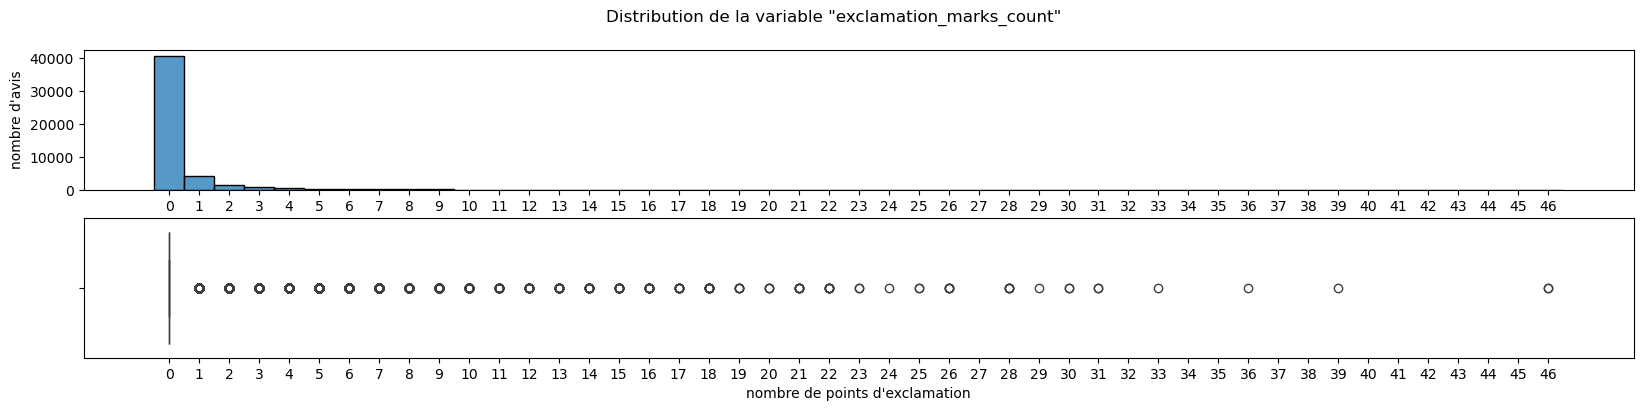

In [ ]:
# Distribution de la variable "exclamation_marks_count"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

sns.histplot(x='exclamation_marks_count', data=df, discrete=True, legend=False, ax=axes[0])
sns.boxplot(x='exclamation_marks_count', data=df, ax=axes[1])

axes[1].set_xticks(np.arange(0, df['exclamation_marks_count'].max() + 1))
axes[0].tick_params(axis='x', labelbottom=True)
axes[1].set_xlabel('nombre de points d\'exclamation')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "exclamation_marks_count"')

plt.show()

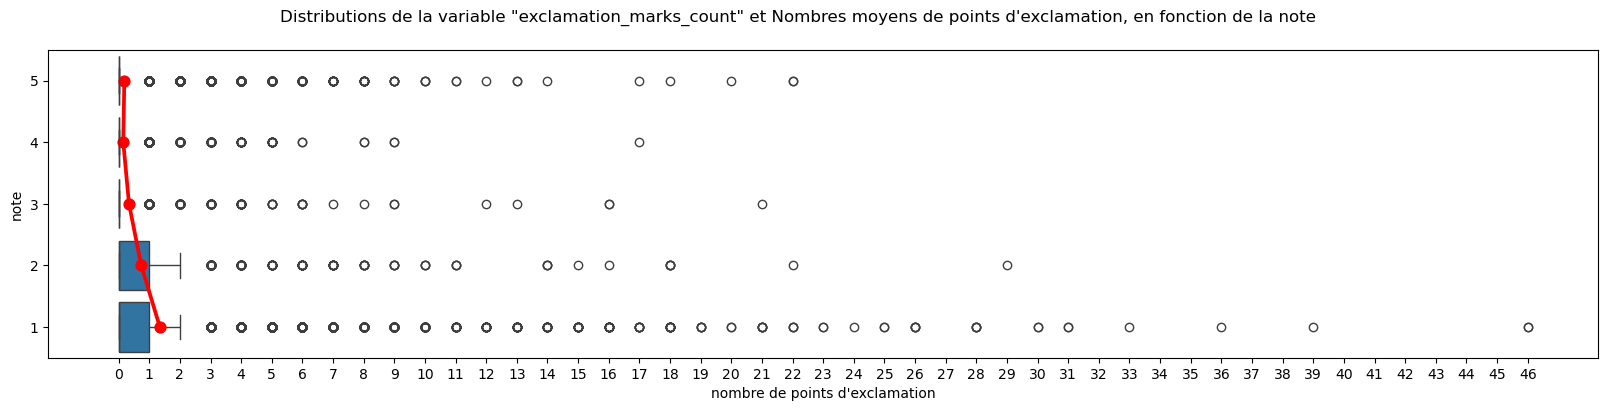

In [471]:
# Distributions de la variable "exclamation_marks_count" et Nombres moyens de points d'exclamation, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='exclamation_marks_count', y='rating', orient='h', data=df)
sns.pointplot(x='exclamation_marks_count', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(0, df['exclamation_marks_count'].max() + 1))
plt.gca().invert_yaxis()
plt.xlabel('nombre de points d\'exclamation')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "exclamation_marks_count" et Nombres moyens de points d\'exclamation, en fonction de la note')

plt.show()

In [472]:
group_1 = df[df['rating'] == 1]['exclamation_marks_count']
group_2 = df[df['rating'] == 2]['exclamation_marks_count']
group_3 = df[df['rating'] == 3]['exclamation_marks_count']
group_4 = df[df['rating'] == 4]['exclamation_marks_count']
group_5 = df[df['rating'] == 5]['exclamation_marks_count']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['exclamation_marks_count'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['exclamation_marks_count'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 4153.28
Test de Kendall --> P-value : 0.0 et Statistique tau : -0.23
Test de Spearman --> P-value : 0.0 et Statistique rho : -0.24


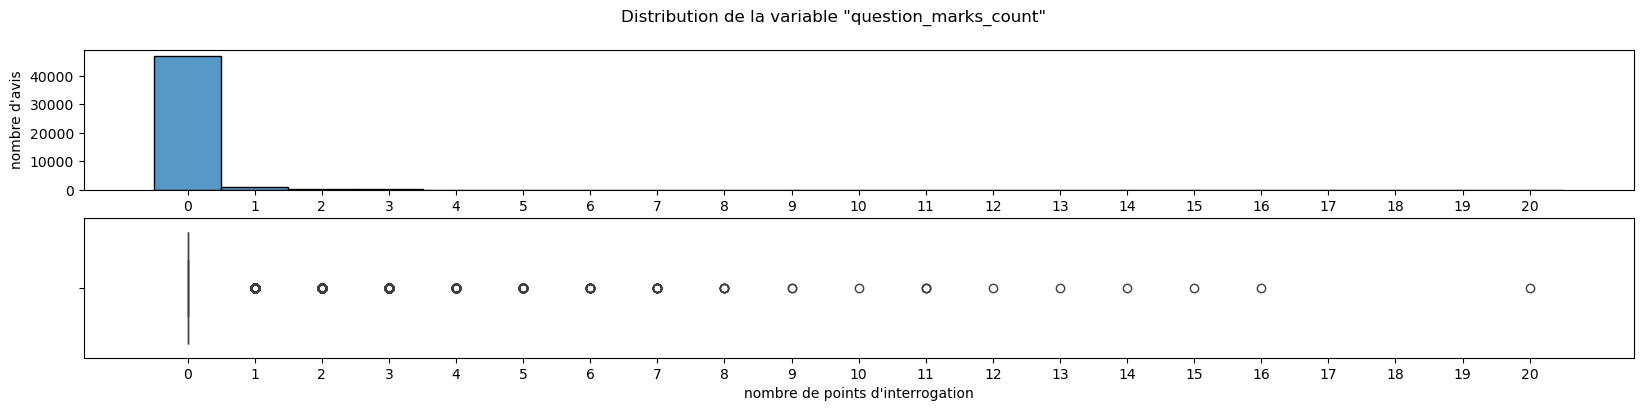

In [ ]:
# Distribution de la variable "question_marks_count"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

sns.histplot(x='question_marks_count', data=df, discrete=True, legend=False, ax=axes[0])
sns.boxplot(x='question_marks_count', data=df, ax=axes[1])

axes[1].set_xticks(np.arange(0, df['question_marks_count'].max() + 1))
axes[0].tick_params(axis='x', labelbottom=True)
axes[1].set_xlabel('nombre de points d\'interrogation')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "question_marks_count"')

plt.show()

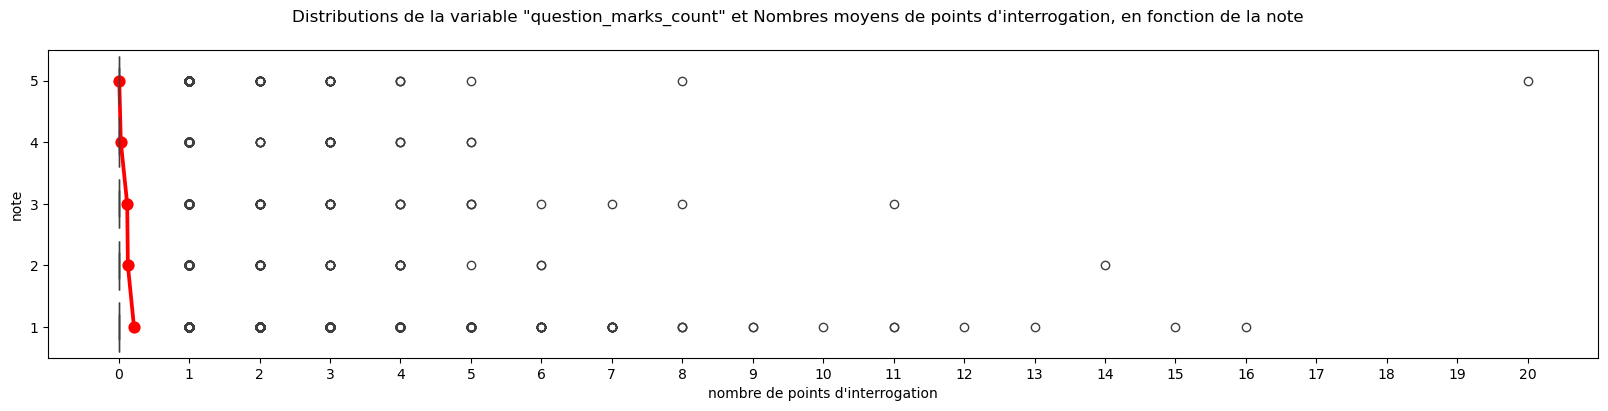

In [474]:
# Distributions de la variable "question_marks_count" et Nombres moyens de points d'interrogation, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='question_marks_count', y='rating', orient='h', data=df)
sns.pointplot(x='question_marks_count', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(0, df['question_marks_count'].max() + 1))
plt.gca().invert_yaxis()
plt.xlabel('nombre de points d\'interrogation')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "question_marks_count" et Nombres moyens de points d\'interrogation, en fonction de la note')

plt.show()

In [475]:
group_1 = df[df['rating'] == 1]['question_marks_count']
group_2 = df[df['rating'] == 2]['question_marks_count']
group_3 = df[df['rating'] == 3]['question_marks_count']
group_4 = df[df['rating'] == 4]['question_marks_count']
group_5 = df[df['rating'] == 5]['question_marks_count']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['question_marks_count'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['question_marks_count'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 2577.39
Test de Kendall --> P-value : 0.0 et Statistique tau : -0.2
Test de Spearman --> P-value : 0.0 et Statistique rho : -0.22


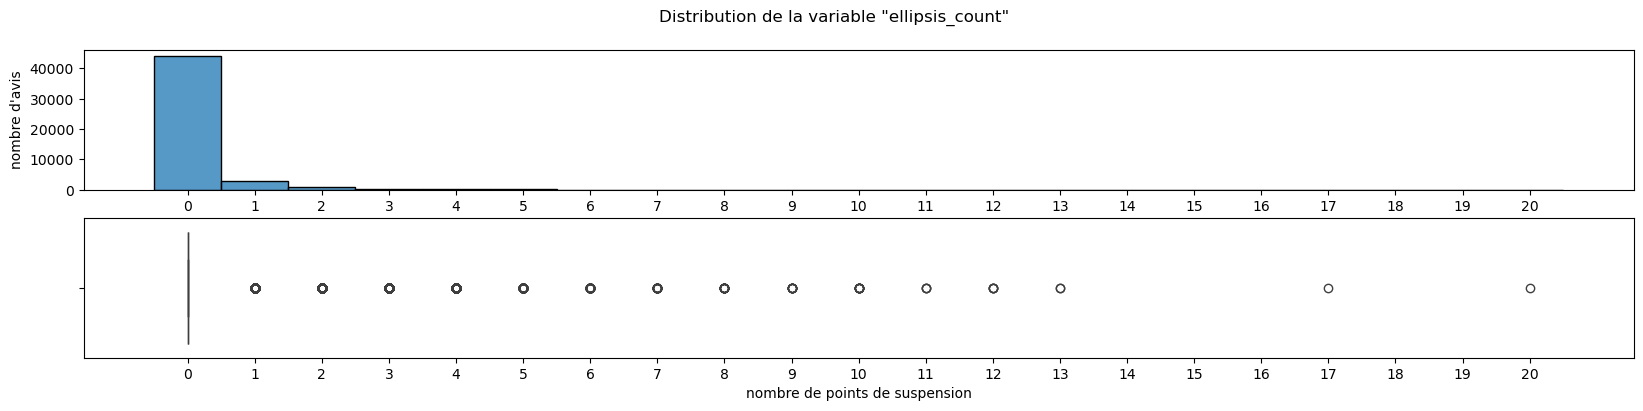

In [ ]:
# Distribution de la variable "ellipsis_count"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

sns.histplot(x='ellipsis_count', data=df, discrete=True, legend=False, ax=axes[0])
sns.boxplot(x='ellipsis_count', data=df, ax=axes[1])

axes[1].set_xticks(np.arange(0, df['ellipsis_count'].max() + 1))
axes[0].tick_params(axis='x', labelbottom=True)
axes[1].set_xlabel('nombre de points de suspension')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "ellipsis_count"')

plt.show()

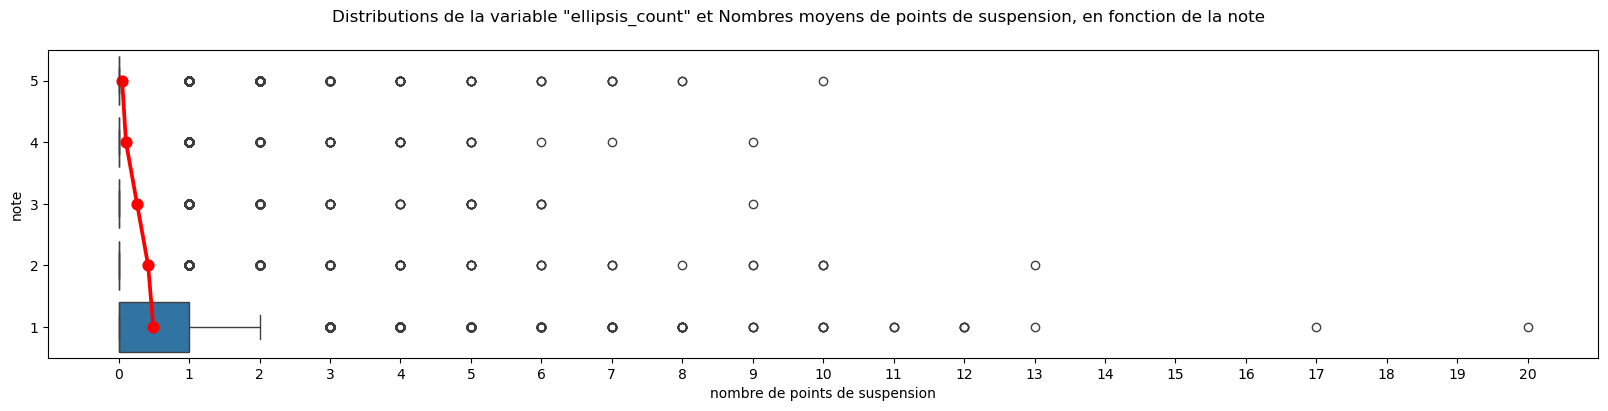

In [477]:
# Distributions de la variable "ellipsis_count" et Nombres moyens de points de suspension, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='ellipsis_count', y='rating', orient='h', data=df)
sns.pointplot(x='ellipsis_count', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(0, df['ellipsis_count'].max() + 1))
plt.gca().invert_yaxis()
plt.xlabel('nombre de points de suspension')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "ellipsis_count" et Nombres moyens de points de suspension, en fonction de la note')

plt.show()

In [478]:
group_1 = df[df['rating'] == 1]['ellipsis_count']
group_2 = df[df['rating'] == 2]['ellipsis_count']
group_3 = df[df['rating'] == 3]['ellipsis_count']
group_4 = df[df['rating'] == 4]['ellipsis_count']
group_5 = df[df['rating'] == 5]['ellipsis_count']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['ellipsis_count'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['ellipsis_count'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 4567.9
Test de Kendall --> P-value : 0.0 et Statistique tau : -0.27
Test de Spearman --> P-value : 0.0 et Statistique rho : -0.29


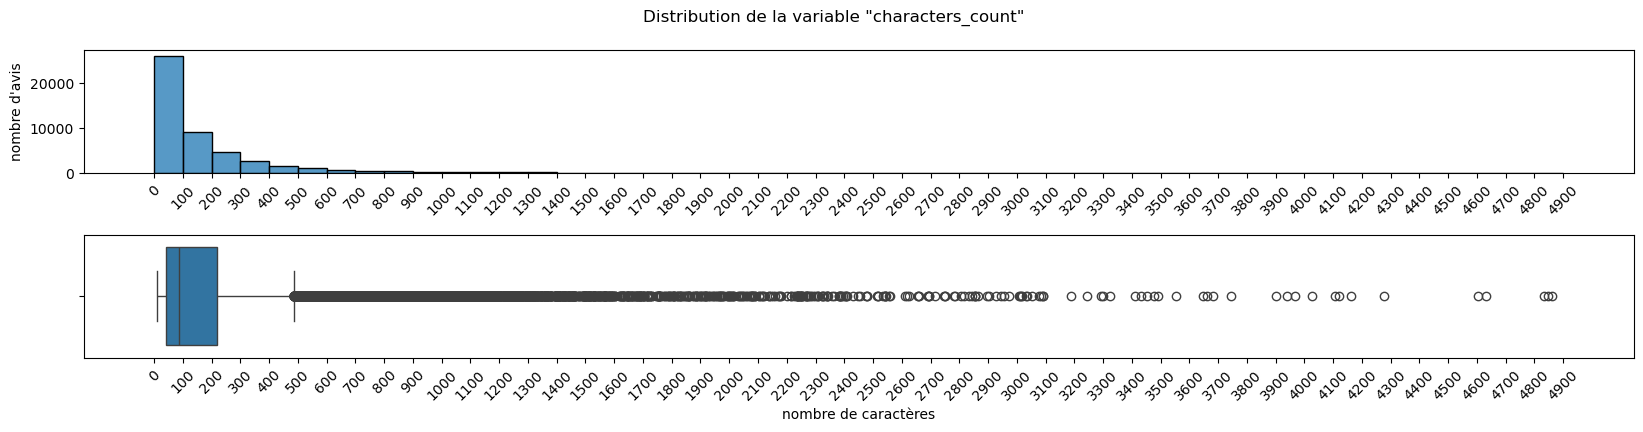

In [ ]:
# Distribution de la variable "characters_count"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

bins = np.arange(0, df['characters_count'].max() + 100, 100)

sns.histplot(x='characters_count', data=df, bins=bins, legend=False, ax=axes[0])
sns.boxplot(x='characters_count', data=df, ax=axes[1])

axes[1].set_xticks(bins)
axes[0].tick_params(axis='x', labelbottom=True, rotation=45)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('nombre de caractères')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "characters_count"')
plt.subplots_adjust(hspace=0.5)

plt.show()

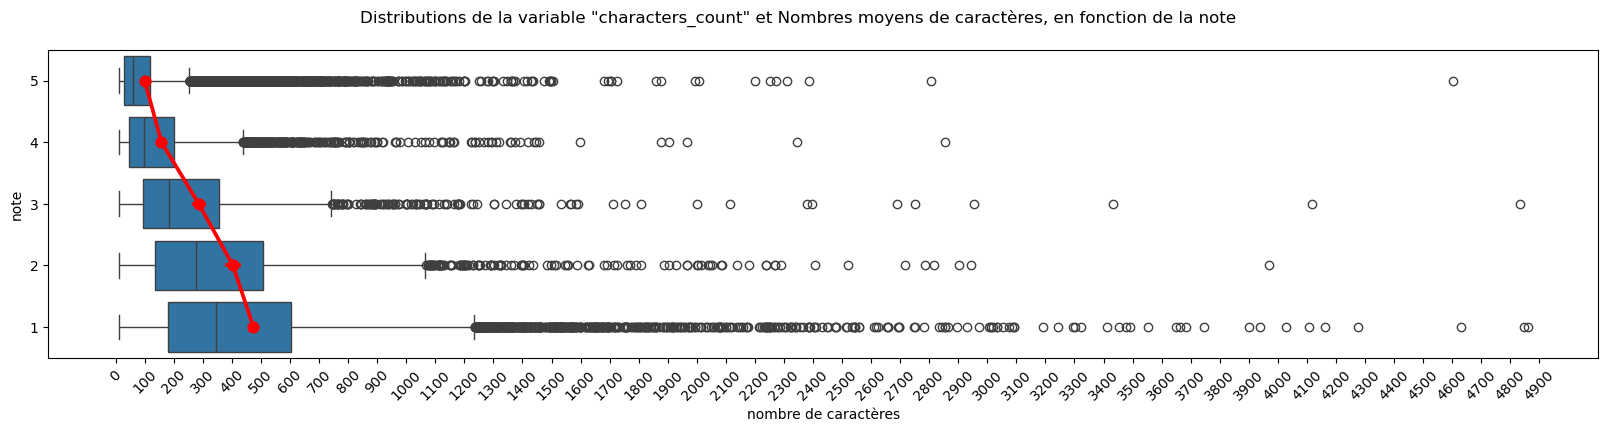

In [480]:
# Distributions de la variable "characters_count" et Nombres moyens de caractères, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='characters_count', y='rating', orient='h', data=df)
sns.pointplot(x='characters_count', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(0, df['characters_count'].max() + 100, 100))
plt.tick_params(axis='x', rotation=45)
plt.gca().invert_yaxis()
plt.xlabel('nombre de caractères')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "characters_count" et Nombres moyens de caractères, en fonction de la note')

plt.show()

In [481]:
group_1 = df[df['rating'] == 1]['characters_count']
group_2 = df[df['rating'] == 2]['characters_count']
group_3 = df[df['rating'] == 3]['characters_count']
group_4 = df[df['rating'] == 4]['characters_count']
group_5 = df[df['rating'] == 5]['characters_count']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['characters_count'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['characters_count'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 14552.41
Test de Kendall --> P-value : 0.0 et Statistique tau : -0.42
Test de Spearman --> P-value : 0.0 et Statistique rho : -0.53


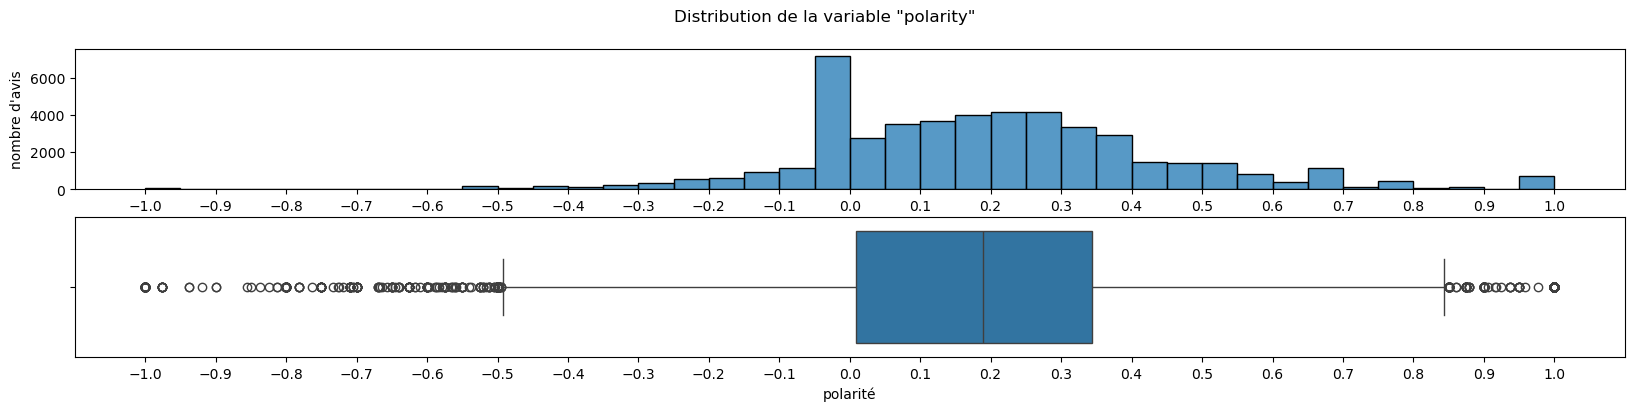

In [ ]:
# Distribution de la variable "polarity"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

bins = np.arange(df['polarity'].min(), df['polarity'].max() + 0.05, 0.05)

sns.histplot(x='polarity', data=df, bins=bins, legend=False, ax=axes[0])
sns.boxplot(x='polarity', data=df, ax=axes[1])

axes[1].set_xticks(np.arange(df['polarity'].min(), df['polarity'].max() + 0.1, 0.1))
axes[0].tick_params(axis='x', labelbottom=True)
axes[1].set_xlabel('polarité')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "polarity"')

plt.show()

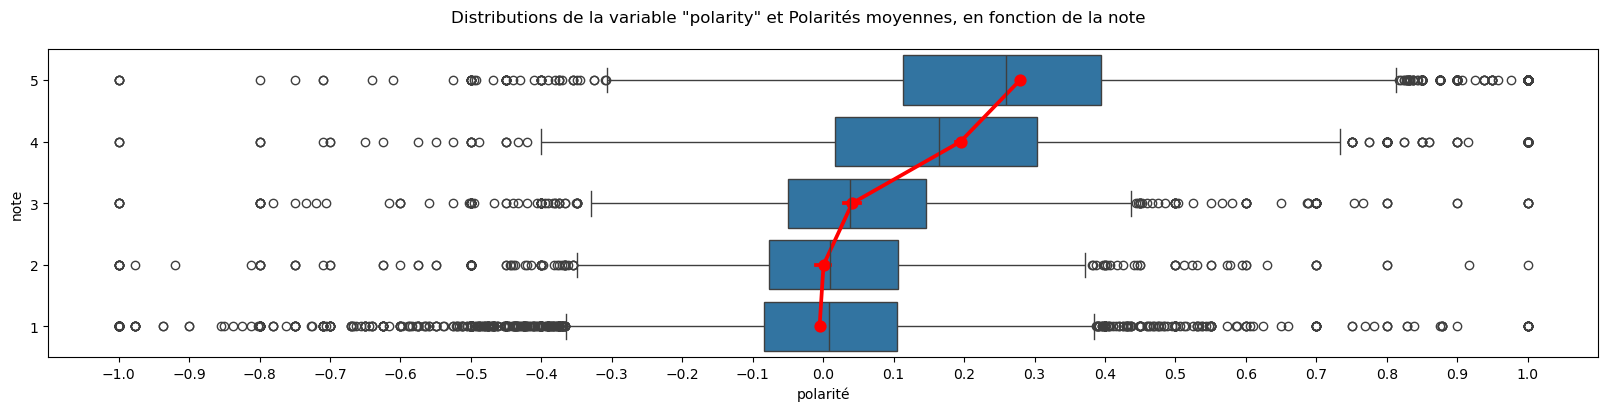

In [483]:
# Distributions de la variable "polarity" et Polarités moyennes, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='polarity', y='rating', orient='h', data=df)
sns.pointplot(x='polarity', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(df['polarity'].min(), df['polarity'].max() + 0.1, 0.1))
plt.gca().invert_yaxis()
plt.xlabel('polarité')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "polarity" et Polarités moyennes, en fonction de la note')

plt.show()

In [ ]:
group_1 = df[df['rating'] == 1]['polarity']
group_2 = df[df['rating'] == 2]['polarity']
group_3 = df[df['rating'] == 3]['polarity']
group_4 = df[df['rating'] == 4]['polarity']
group_5 = df[df['rating'] == 5]['polarity']

# Test ANOVA à 1 facteur (F-test) (Param’) - Analyse la variance des groupes et Compare les moyennes des groupes en utilisant la variance.
# >>> Calcul de l'asymétrie (skewness) + Test de normalité d'Anderson-Darling (A²-test) (Non param’) OU Q-Q plot + Test d’homogénéité des variances de Levene à faire avant... <<<
F, p_value_ANOVA = f_oneway(group_1, group_2, group_3, group_4, group_5)
print('Test ANOVA -->', f'P-value : {round(p_value_ANOVA, 2)}', f'et Statistique F : {round(F, 2)}')

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['polarity'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['polarity'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}', end='\n\n')

# Test de Tukey (q-test) (Param’) appliqué si l'ANOVA est significative (P-value < 0.05)
# >>> Calcul de l'asymétrie (skewness) + Test de normalité d'Anderson-Darling (A²-test) (Non param’) OU Q-Q plot + Test d’homogénéité des variances de Levene à faire avant... <<<
if p_value_ANOVA < 0.05:
    tukey = pairwise_tukeyhsd(df['polarity'], df['rating'], alpha=0.05)
    print(tukey)

Test ANOVA --> P-value : 0.0 et Statistique F : 3322.21
Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 11827.99
Test de Kendall --> P-value : 0.0 et Statistique tau : 0.38
Test de Spearman --> P-value : 0.0 et Statistique rho : 0.48

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0056 0.8873 -0.0109 0.0222  False
     1      3   0.0463    0.0    0.03 0.0626   True
     1      4   0.2001    0.0  0.1887 0.2114   True
     1      5   0.2846    0.0  0.2772 0.2921   True
     2      3   0.0407    0.0  0.0194  0.062   True
     2      4   0.1944    0.0  0.1767 0.2122   True
     2      5    0.279    0.0  0.2634 0.2946   True
     3      4   0.1538    0.0  0.1362 0.1713   True
     3      5   0.2383    0.0   0.223 0.2536   True
     4      5   0.0846    0.0  0.0747 0.0944   True
---------------------------------------------------


In [ ]:
'''
Toutes les comparaisons de moyennes entre les groupes sont significatives (reject = True) sauf
entre les groupes 1 et 2, où la différence est faible (meandiff = 0.0056) et non significative (p-adj = 0.8873).

La plus grande différence significative est observée entre les groupes 1 et 5 (meandiff = 0.2846), avec un intervalle de confiance étroit (lower = 0.2772, upper = 0.2921),
ce qui indique une estimation précise de cette différence.
'''

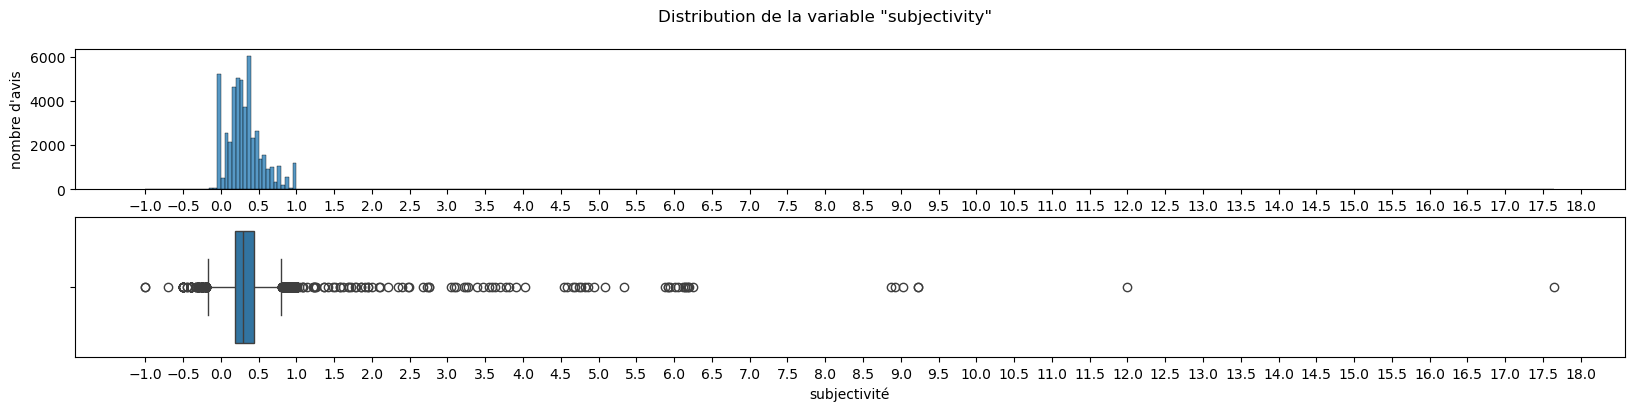

In [ ]:
# Distribution de la variable "subjectivity"
fig, axes = plt.subplots(2, 1, figsize=(20,4), sharex=True)

bins = np.arange(df['subjectivity'].min(), df['subjectivity'].max() + 0.05, 0.05)

sns.histplot(x='subjectivity', data=df, bins=bins, legend=False, ax=axes[0])
sns.boxplot(x='subjectivity', data=df, ax=axes[1])

axes[1].set_xticks(np.arange(df['subjectivity'].min(), df['subjectivity'].max() + 0.5, 0.5))
axes[0].tick_params(axis='x', labelbottom=True)
axes[1].set_xlabel('subjectivité')
axes[0].set_ylabel('nombre d\'avis')
plt.suptitle('Distribution de la variable "subjectivity"')

plt.show()

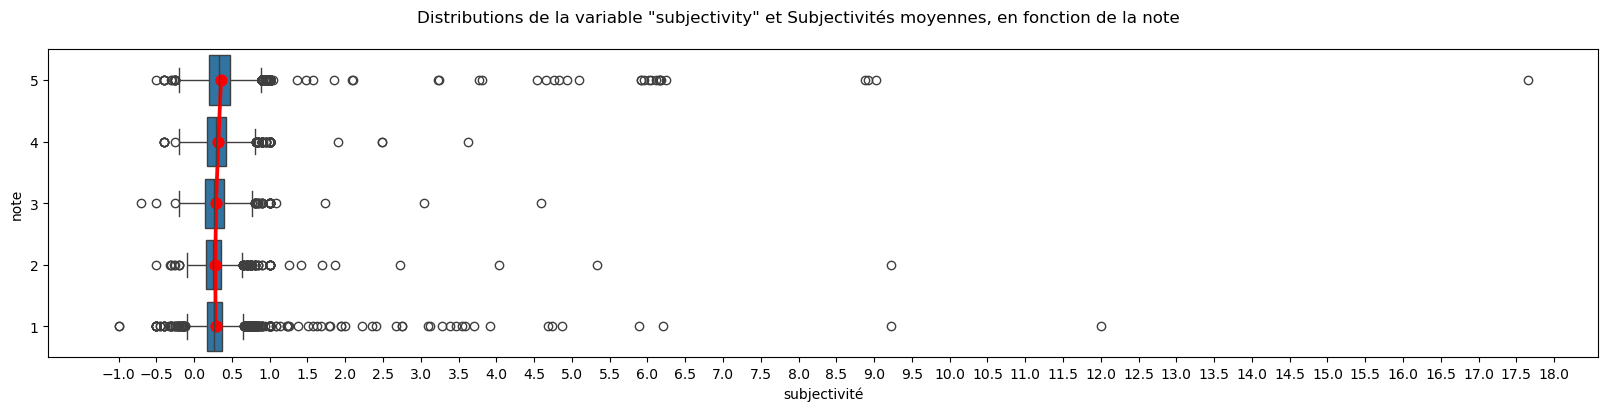

In [487]:
# Distributions de la variable "subjectivity" et Subjectivités moyennes, en fonction de la note
plt.figure(figsize=(20,4))

sns.boxplot(x='subjectivity', y='rating', orient='h', data=df)
sns.pointplot(x='subjectivity', y='rating', orient='h', data=df, color='r')

plt.xticks(np.arange(df['subjectivity'].min(), df['subjectivity'].max() + 0.5, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('subjectivité')
plt.ylabel('note')
plt.suptitle('Distributions de la variable "subjectivity" et Subjectivités moyennes, en fonction de la note')

plt.show()

In [488]:
group_1 = df[df['rating'] == 1]['subjectivity']
group_2 = df[df['rating'] == 2]['subjectivity']
group_3 = df[df['rating'] == 3]['subjectivity']
group_4 = df[df['rating'] == 4]['subjectivity']
group_5 = df[df['rating'] == 5]['subjectivity']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4, group_5)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test de Kendall (Non param’) - Moins sensible aux valeurs extrêmes que Spearman.
tau, p_value = kendalltau(df['rating'], df['subjectivity'])
print('Test de Kendall -->', f'P-value : {round(p_value, 2)}', f'et Statistique tau : {round(tau, 2)}')

# Test de Spearman (Non param’)
rho, p_value = spearmanr(df['rating'], df['subjectivity'])
print('Test de Spearman -->', f'P-value : {round(p_value, 2)}', f'et Statistique rho : {round(rho, 2)}')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 827.07
Test de Kendall --> P-value : 0.0 et Statistique tau : 0.1
Test de Spearman --> P-value : 0.0 et Statistique rho : 0.13


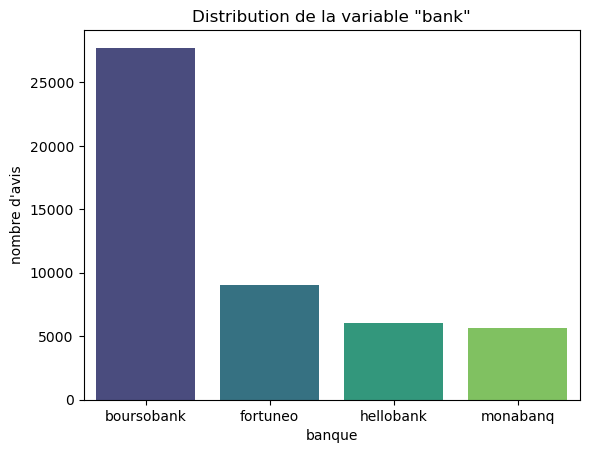

In [489]:
# Distribution de la variable "bank"
sns.countplot(x='bank', hue='bank', data=df, palette='viridis', legend=False)
plt.xlabel('banque')
plt.ylabel('nombre d\'avis')
plt.title('Distribution de la variable "bank"');

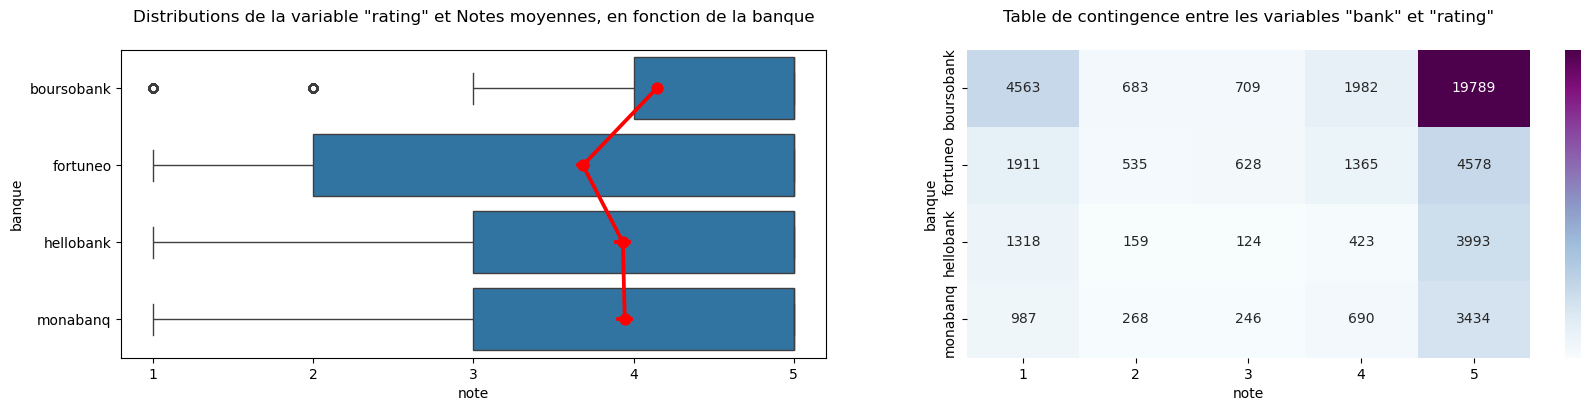

In [490]:
# Distributions de la variable "rating" et Notes moyennes, en fonction de la banque
fig, axes = plt.subplots(1, 2, figsize=(20,4))

sns.boxplot(x='rating', y='bank', orient='h', data=df, ax=axes[0])
sns.pointplot(x='rating', y='bank', orient='h', data=df, color='r', ax=axes[0])

axes[0].set_xticks(np.arange(df['rating'].min(), df['rating'].max() + 1))
axes[0].set_xlabel('note')
axes[0].set_ylabel('banque')
axes[0].set_title('Distributions de la variable "rating" et Notes moyennes, en fonction de la banque', pad=20)

contingency_table = pd.crosstab(df['bank'], df['rating'])
sns.heatmap(data=contingency_table, cmap='BuPu', annot=True, fmt='g', cbar_kws={"ticks":[]}, ax=axes[1])
axes[1].set_xlabel('note')
axes[1].set_ylabel('banque')
axes[1].set_title('Table de contingence entre les variables "bank" et "rating"', pad=20)

plt.show()

In [495]:
group_1 = df[df['bank'] == 'boursobank']['rating']
group_2 = df[df['bank'] == 'fortuneo']['rating']
group_3 = df[df['bank'] == 'hellobank']['rating']
group_4 = df[df['bank'] == 'monabanq']['rating']

# Test de Kruskal-Wallis (H-test) (Non param’) - Compare les distributions des groupes en utilisant les rangs. Moins sensible aux valeurs extrêmes que ANOVA.
H, p_value = kruskal(group_1, group_2, group_3, group_4)
print('Test de Kruskal-Wallis -->', f'P-value : {round(p_value, 2)}', f'et Statistique H : {round(H, 2)}')

# Test du Khi² (χ²-test) (Non param’)
chi2_results = chi2_contingency(contingency_table)
print('Test du Khi² -->', f'P-value : {round(chi2_results[1], 2)}', f'et Statistique χ² : {round(chi2_results[0], 2)}')

# Coefficient V de Cramér
n = np.sum(contingency_table.values)
min_dim = min(contingency_table.shape) - 1
V = np.sqrt(chi2_results[0] / (n * min_dim))
print(f'Le V de Cramér est de {round(V, 2)}, càd compris entre 0.1 ≤ V < 0.3 ce qui fait que l\'association est faible entre \
la variable explicative "bank" et la variable cible "rating".')

Test de Kruskal-Wallis --> P-value : 0.0 et Statistique H : 1038.62
Test du Khi² --> P-value : 0.0 et Statistique χ² : 1864.62
Le V de Cramér est de 0.11, càd compris entre 0.1 ≤ V < 0.3 ce qui fait que l'association est faible entre la variable explicative "bank" et la variable cible "rating".


**Résumé des Tests statistiques :**  
(toutes les P-values sont à 0.0 donc les relations entre les variables explicatives et la variable cible "rating" sont statistiquement significatives,  
ce qui signifie qu’on peut rejeter l’hypothèse nulle d’absence d’effet pour chacun des tests)

| Variable explicative      | Kruskal-Wallis (H) | Kendall (tau) | Spearman (rho) | Corrélation         | Conclusion                         |
| ------------------------- | ------------------ | ------------- | -------------- | ------------------- | ---------------------------------- |
| `exclamation_marks_count` | 4153.28            | -0.23         | -0.24          | Faible              | Lien faible mais significatif      |
| `question_marks_count`    | 2577.39            | -0.20         | -0.22          | Faible              | Lien faible mais significatif      |
| `suspension_points_count` | 4567.9             | -0.27         | -0.29          | Faible à modérée    | Lien un peu plus fort              |
| `characters_count`        | 14552.41           | -0.42         | -0.53          | Modérée à forte     | **Lien important et négatif**      |
| `polarity`                | 11827.99           | 0.38          | 0.48           | Modérée             | **Lien fort et positif**           |
| `subjectivity`            | 827.07             | 0.10          | 0.13           | Très faible         | Lien très faible mais significatif |

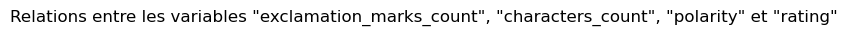

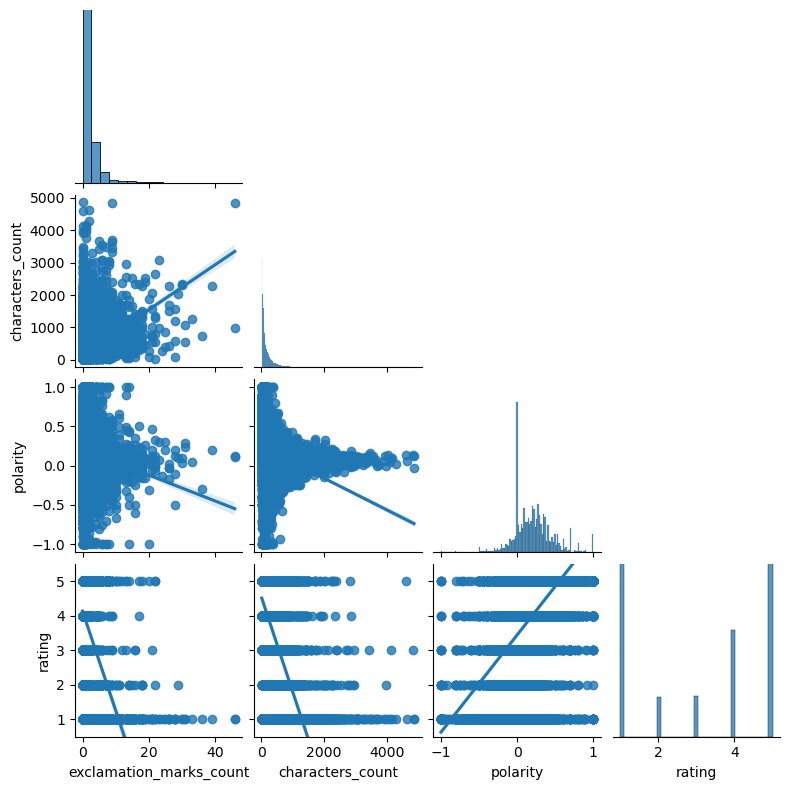

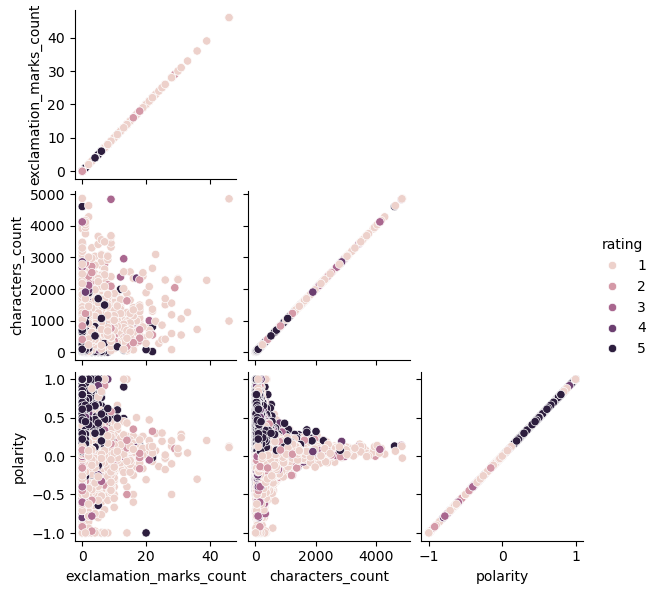

In [ ]:
# Relations entre les variables "exclamation_marks_count", "characters_count", "polarity" et "rating"
plt.figure(figsize=(1,0.1))
plt.suptitle('Relations entre les variables "exclamation_marks_count", "characters_count", "polarity" et "rating"')
plt.axis('off')
plt.show()

fig1 = sns.pairplot(df[['exclamation_marks_count', 'characters_count', 'polarity', 'rating']], kind='reg', diag_kind='hist', height=2, corner=True)
fig2 = sns.pairplot(df[['exclamation_marks_count', 'characters_count', 'polarity', 'rating']], diag_kind=None, hue='rating', height=2, corner=True)

fig1.axes[3,0].set_ylim(0.5, 5.5)
fig1.diag_axes[1].set_ylim(0, 26100)
fig1.diag_axes[2].set_ylim(0, 7200)

plt.show()

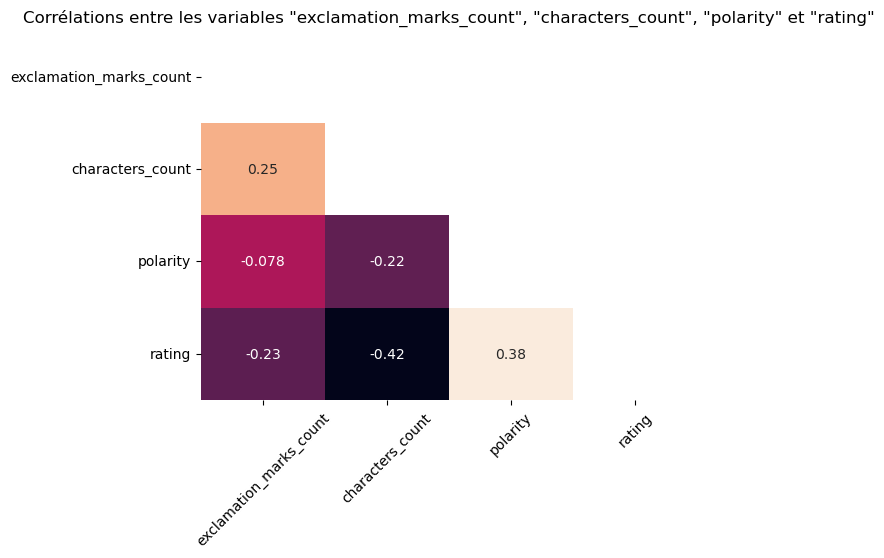

In [ ]:
# Corrélations entre les variables "exclamation_marks_count", "characters_count", "polarity" et "rating"
corr = df[['exclamation_marks_count', 'characters_count', 'polarity', 'rating']].corr(method='kendall')
mask = np.triu(np.ones_like(df[['exclamation_marks_count', 'characters_count', 'polarity', 'rating']].corr(method='kendall'), dtype=bool))

sns.heatmap(data=corr, annot=True, cbar=False, mask=mask)
plt.title('Corrélations entre les variables "exclamation_marks_count", "characters_count", "polarity" et "rating"')
plt.xticks(rotation=45);

In [498]:
# Sauvegarde du DataFrame traité (multiclass) dans un fichier Parquet

# >>> ATTENTION ! <<< un fichier Parquet existe déjà dans "data/processed/"
#df.to_parquet('../data/processed/processed_reviews_multiclass.parquet', index=False)

### Axes d'amélioration possibles

In [ ]:
'''
Sur les avis :
- Détection de la Langue
- Correction des Fautes d'orthographe
- N-grams (bigrams, trigrams, ...) pour capturer le contexte local dans les avis
- Maintien des Mots négatifs ("ne", "pas", "aucun", "jamais", "rien", ...)
- Suppression des Caractères d'échappement éventuels ("\n", "\t", ...)
- Suppression d'Acronymes éventuels ("TL;DR", ...)
- Gestion des Valeurs extrêmes (à conserver totalement ? à conserver partiellement ? à tout supprimer ?)
- Analyse de plusieurs "?", "!" (ou autres caractères spéciaux) consécutifs en fonction de la note

Sur les dates :
- Analyse de la Différence entre la date d'expérience et la date de publication en fonction de la note
'''